# Введение в детали проекта

## Описание процесса обработки

Сталь обрабатывается в металлическом ковше, который вмещает около 100 тонн. Чтобы ковш выдерживал высокие температуры, его внутреннюю поверхность облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и нагревают до необходимой температуры с помощью графитовых электродов, установленных на крышке ковша.

Первым этапом идет десульфурация, при которой из стали удаляется сера и корректируется её химический состав путем добавления различных примесей. Затем сталь легируют, добавляя в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку с помощью специального трайб-аппарата.

Перед первым введением легирующих добавок специалисты проводят химический анализ стали и измеряют её температуру. Затем температура на несколько минут повышается, после чего добавляются легирующие материалы, и сталь продувается инертным газом для перемешивания, а затем снова проводится измерение. Этот цикл повторяется до тех пор, пока не будет достигнут необходимый химический состав стали и оптимальная температура плавки.

После этого расплавленная сталь направляется на доводку металла или поступает в машину непрерывной разливки, откуда выходит готовый продукт в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных

Данные хранятся в базе данных `PostgreSQL`. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1` … `Bulk15` — объём подаваемого материала.

Таблица `steel.data_bulk_time`
- key — номер партии;
- `Bulk1` … `Bulk15` — время подачи материала.

Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.

Таблица `steel.data_temp`
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1` … `Wire15` — объём подаваемых проволочных материалов.

Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1` … `Wire15` — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 1. Импорт библиотек, инициализация констант и базовых функций

In [ ]:
%%capture

!pip install --upgrade scikit-learn
!pip install --upgrade catboost
!pip install --upgrade pandas
!pip install phik -q
!pip install missingno
!pip install scikeras
!pip install shap
!pip install lime

In [ ]:
from sqlalchemy import create_engine #библиотека для подключения к серверу с БД

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime, timedelta
import random as python_random

import phik #библиотека для построения корреляционной матрицы
import missingno as msno #библбиотека для графического представления пропусков в данных

from functools import reduce #фреймворк для объединения нескольких таблиц в одну

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, ReLU, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

import lime
from lime import lime_tabular

In [ ]:
RANDOM_STATE = 200424

In [ ]:
#функция для отображения основной информации о датасете
def get_data_info(data):
  print('Вывод некоторых записей из датафрейма:\n')
  display(data.head(7))
  display(HTML('<hr style="border:2px solid black; width:100%"/>'))

  print('\nИнформация о датасете:\n')
  display(data.info())
  display(HTML('<hr style="border:2px solid black; width:100%"/>'))

  print('\nРаспределения значений в данных:\n')
  display(data.describe(include='all'))
  display(HTML('<hr style="border:2px solid black; width:100%"/>'))

  sns.set()
  msno.bar(data, figsize=(10, 4))
  plt.title('Столбчатая диаграмма полноты данных по столбцам', fontsize=15, pad=10)
  plt.show()
  display(HTML('<hr style="border:2px solid black; width:100%"/>'))

  msno.matrix(data, figsize=(10, 4))
  plt.title('Отображение пропущенных значений с высокой плотностью данных', fontsize=15, pad=10)
  plt.show()
  display(HTML('<hr style="border:2px solid black; width:100%"/>'))

#построение гистограмм для указанных столбцов датафрейма
def plot_distributions(data, columns):
  sns.set()
  for column in columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Распределение для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

## 2 Работа с данными

### 2.1 Подключение к SQL-базе (Яндекса). Загрузка таблиц sql.

In [ ]:
%%time

#строка с данными для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
  db_config['user'],
  db_config['pwd'],
  db_config['host'],
  db_config['port'],
  db_config['db'],
)

#создание соединения с SQL-сервером, откуда будем подтягивать данные
engine = create_engine(connection_string)

CPU times: user 46.7 ms, sys: 7.42 ms, total: 54.1 ms
Wall time: 129 ms


In [ ]:
data_arc_query = '''
SELECT *
FROM steel.data_arc
'''

data_bulk_query = '''
SELECT *
FROM steel.data_bulk
'''

data_bulk_time_query = '''
SELECT *
FROM steel.data_bulk_time
'''

data_gas_query = '''
SELECT *
FROM steel.data_gas
'''

data_temp_query = '''
SELECT *
FROM steel.data_temp
'''

data_wire_query = '''
SELECT *
FROM steel.data_wire
'''

data_wire_time_query = '''
SELECT *
FROM steel.data_wire_time
'''

In [ ]:
data_arc = pd.read_sql_query(data_arc_query, con=engine)
data_bulk = pd.read_sql_query(data_bulk_query, con=engine)
data_bulk_time = pd.read_sql_query(data_bulk_time_query, con=engine)
data_gas = pd.read_sql_query(data_gas_query, con=engine)
data_temp = pd.read_sql_query(data_temp_query, con=engine)
data_wire = pd.read_sql_query(data_wire_query, con=engine)
data_wire_time = pd.read_sql_query(data_wire_time_query, con=engine)

## 2.2 Исследовательский анализ и предобработка данных

### 2.2.0 Функции необходимые для обработки данных

In [ ]:
#функция для преобразования времени в datetime с фиктивной датой
def time_to_datetime(time_obj):
  #выберем любое время, так как нам это не сильно важно
  base_date = datetime(2000, 1, 1)
  return datetime.combine(base_date, time_obj)

#обработка случаев, когда конечное время наступает после полуночи (переход на следующий день)
def adjust_end_time(row, start_col, end_col):
    start = time_to_datetime(row[start_col])
    end = time_to_datetime(row[end_col])
    if end < start:
        end += timedelta(days=1)
    return end

#функция нахождения разности между начальным и конечным временем
def calculate_time_difference(data, start_col, end_col):
  df = data.copy()
  #преобразование времени начала и конца в datetime
  df['start_datetime'] = df[start_col].apply(time_to_datetime)
  df['end_datetime'] = df.apply(adjust_end_time, axis=1, start_col=start_col, end_col=end_col)

  #вычисление временной разницы
  time_difference = df['end_datetime'] - df['start_datetime']

  return time_difference

### 2.2.1 Таблица `steel.data_arc`

#### 2.2.1.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key BeginHeat   EndHeat  ActivePower  ReactivePower
0    1  11:02:14  11:06:02     0.976059       0.687084
1    1  11:07:28  11:10:33     0.805607       0.520285
2    1  11:11:44  11:14:36     0.744363       0.498805
3    1  11:18:14  11:24:19     1.659363       1.062669
4    1  11:26:09  11:28:37     0.692755       0.414397
5    2  11:34:14  11:36:31     0.438063       0.283043
6    2  11:38:50  11:44:28     1.296415       0.892914


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Распределения значений в данных:



key BeginHeat   EndHeat   ActivePower  ReactivePower
count   14876.000000     14876     14876  14876.000000   14876.000000
unique           NaN     13663     13690           NaN            NaN
top              NaN  23:52:58  22:21:32           NaN            NaN
freq             NaN         4         4           NaN            NaN
mean     1615.220422       NaN       NaN      0.670441       0.452592
std       934.571502       NaN       NaN      0.408159       5.878702
min         1.000000       NaN       NaN      0.030002    -715.504924
25%       806.000000       NaN       NaN      0.395297       0.290991
50%      1617.000000       NaN       NaN      0.555517       0.415962
75%      2429.000000       NaN       NaN      0.857034       0.637371
max      3241.000000       NaN       NaN      3.731596       2.676388

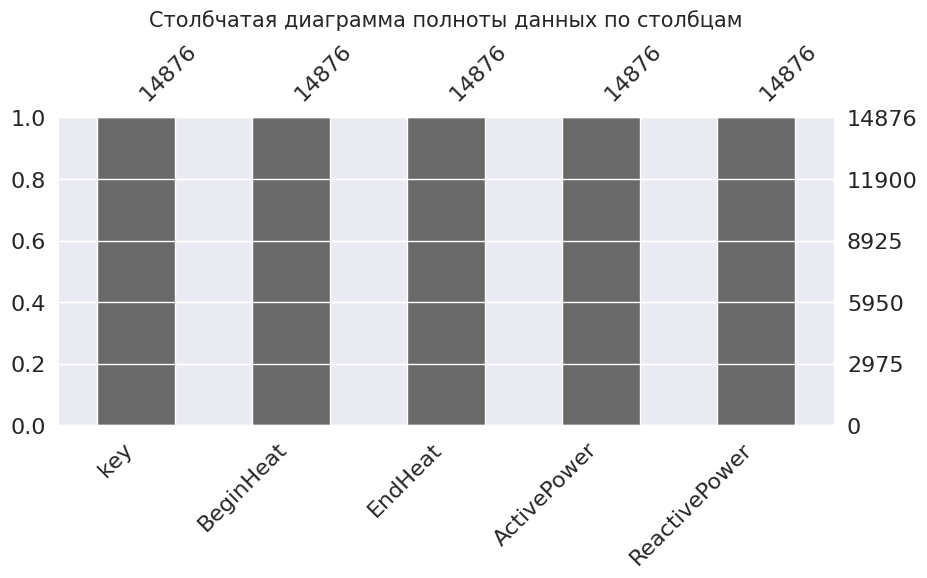

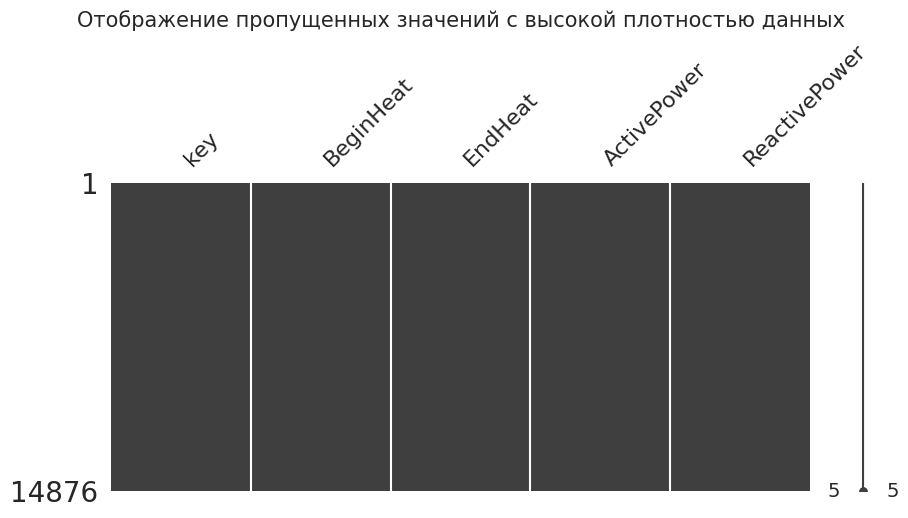

In [ ]:
get_data_info(data_arc)

- В фрейме `data_arc` с данными об электродах нет пропусков;
- В данных имеют место аномалии, так как в столбце `ReactivePower` минимальное значение - отрицательное и чрезмерно большое, что невозможно для указываемой реактивной мощности. В следующем разделе построим графики распределений числовых переменных.

#### 2.2.1.2 Анализ числовых переменных и борьба с выбросами

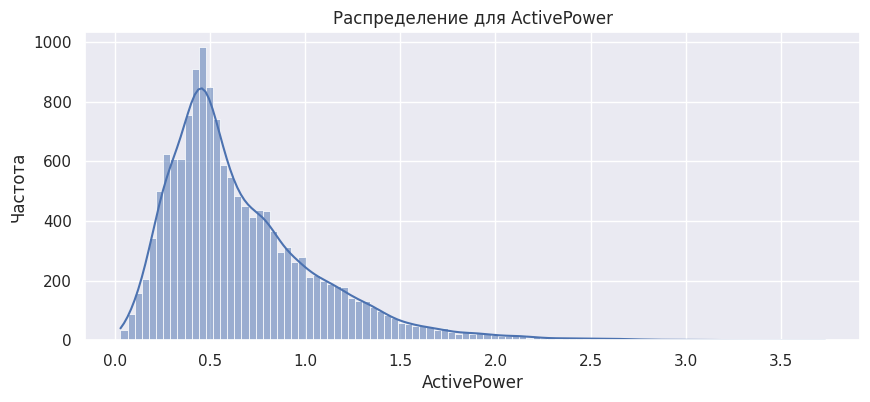

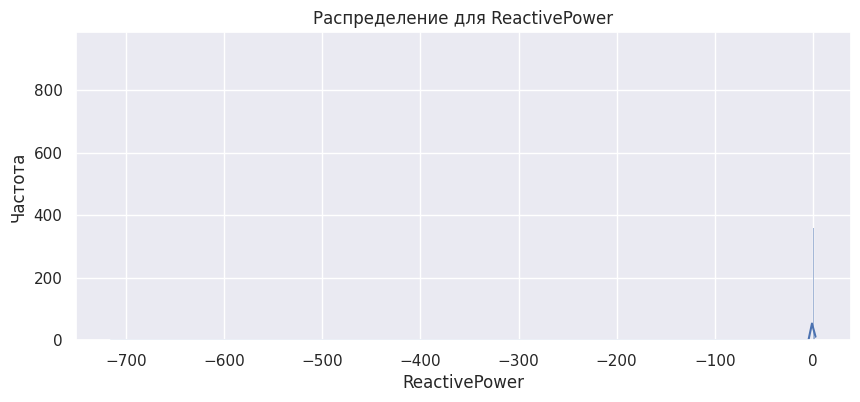

In [ ]:
plot_distributions(data_arc, ['ActivePower', 'ReactivePower'])

Наши данные имеют нормальное распрделение это поможет нам в обучении модели, а также борбе с пропусками и выбросами.

Как можно заметить из гистограммы для рекативной мощности `ReactivePower` там имеют место быть сильные выбросы, к тому же данные выбросы имеют отрицательный знак, что невозможно в условиях нашей работы, где электрод должен только поглощать энергию, следовательно, значение мощности должно быть неотрицательным.

Данный вывод сделан из отсутствия дополнительных сведений от заказчика касаемо конфигурации и управления электроэнергетической системой, так как, например, в системе могут быть установлены устройства для коррекции коэффициента мощности, такие как конденсаторы или синхронные компенсаторы, которые могут давать отрицательную реактивную мощность







In [ ]:
display(data_arc.loc[data_arc['ReactivePower']<0])

key BeginHeat   EndHeat  ActivePower  ReactivePower
9781  2116  00:44:48  00:46:37     0.495782    -715.504924

Как мы видим, аномальное значение находится в единственном экзмепляре, это облегчит нам задачу и снизит влияние выбросов на итоговое качество данных.

In [ ]:
display(data_arc.loc[(data_arc['ActivePower']>0.5555) & (data_arc['ActivePower']<0.556)])

key BeginHeat   EndHeat  ActivePower  ReactivePower
581     127  00:13:38  00:16:25     0.555682       0.466851
2073    446  20:20:19  20:23:04     0.555565       0.393111
2093    450  23:02:09  23:04:29     0.555884       0.396938
3396    735  12:50:17  12:52:48     0.555850       0.386874
4309    924  10:49:13  10:51:16     0.555718       0.369957
4413    949  12:23:21  12:25:23     0.555977       0.365023
5372   1166  19:03:55  19:05:58     0.555933       0.367732
9539   2067  03:27:01  03:29:07     0.555687       0.396826
11739  2559  05:17:38  05:19:59     0.555611       0.421774

С учетом нормальности распределений обоих величин, а также небольшой иллюстрации сверху, можно сделать вывод, что аномальное значение можно заменить значением из того же персентиля для `ReactivePower`, в котором находится значение `ActivePower`

In [ ]:
def calculate_percentile(data, value):
    count_less = (data < value).sum()
    total_count = data.count()
    percentile = count_less / total_count
    return percentile

In [ ]:
#вычисление персентиля для ActivePower < 0
active_power_0 = data_arc.loc[data_arc['ReactivePower'] < 0, 'ActivePower'].iloc[0]
active_power_0_percentile = calculate_percentile(data_arc['ActivePower'], active_power_0)
print(f"Персентиль среднего значения ActivePower: {active_power_0_percentile:.2f}")

#значение ReactivePower для того же персентиля
reactive_power_0 = data_arc['ReactivePower'].quantile(active_power_0_percentile)
print(f"Значение ReactivePower на {active_power_0_percentile:.2f} персентиле: {reactive_power_0}")

#замена значений в столбце ReactivePower для строк с ReactivePower < 0
data_arc.loc[data_arc['ReactivePower'] < 0, 'ReactivePower'] = reactive_power_0

#проверка изменений
display(data_arc[data_arc['ReactivePower'] < 0])

Персентиль среднего значения ActivePower: 0.42
Значение ReactivePower на 0.42 персентиле: 0.37140114220938425


Empty DataFrame
Columns: [key, BeginHeat, EndHeat, ActivePower, ReactivePower]
Index: []

#### 2.2.1.3 Генерация признаков

##### 2.2.1.3.1 Переменные основанные на времени

In [ ]:
#добавление времени нагревания
data_arc['HeatingTime'] = calculate_time_difference(data_arc, 'BeginHeat', 'EndHeat')
print('Таблица после добавления времени нагревания: ')
display(data_arc.head(7))

#создание дополнительных столбцов с временными метками
data_arc['HeatingTime_minutes'] = data_arc['HeatingTime'].apply(lambda x: (x.seconds % 3600) // 60)
data_arc['HeatingTime_seconds'] = data_arc['HeatingTime'].apply(lambda x: x.seconds % 60)
data_arc['HeatingTime_seconds_total'] = data_arc['HeatingTime'].apply(lambda x: x.total_seconds())

#чек результатов
display(HTML('<hr style="border:2px solid black; width:100%"/>'))
print('Получившаяся таблица:')
display(data_arc.head(7))

Таблица после добавления времени нагревания: 


key BeginHeat   EndHeat  ActivePower  ReactivePower     HeatingTime
0    1  11:02:14  11:06:02     0.976059       0.687084 0 days 00:03:48
1    1  11:07:28  11:10:33     0.805607       0.520285 0 days 00:03:05
2    1  11:11:44  11:14:36     0.744363       0.498805 0 days 00:02:52
3    1  11:18:14  11:24:19     1.659363       1.062669 0 days 00:06:05
4    1  11:26:09  11:28:37     0.692755       0.414397 0 days 00:02:28
5    2  11:34:14  11:36:31     0.438063       0.283043 0 days 00:02:17
6    2  11:38:50  11:44:28     1.296415       0.892914 0 days 00:05:38

Получившаяся таблица:


key BeginHeat   EndHeat  ActivePower  ReactivePower     HeatingTime  \
0    1  11:02:14  11:06:02     0.976059       0.687084 0 days 00:03:48   
1    1  11:07:28  11:10:33     0.805607       0.520285 0 days 00:03:05   
2    1  11:11:44  11:14:36     0.744363       0.498805 0 days 00:02:52   
3    1  11:18:14  11:24:19     1.659363       1.062669 0 days 00:06:05   
4    1  11:26:09  11:28:37     0.692755       0.414397 0 days 00:02:28   
5    2  11:34:14  11:36:31     0.438063       0.283043 0 days 00:02:17   
6    2  11:38:50  11:44:28     1.296415       0.892914 0 days 00:05:38   

   HeatingTime_minutes  HeatingTime_seconds  HeatingTime_seconds_total  
0                    3                   48                      228.0  
1                    3                    5                      185.0  
2                    2                   52                      172.0  
3                    6                    5                      365.0  
4                    2                   28                      148.0  
5                    2                   17                      137.0  
6                    5                   38                      338.0

##### 2.2.1.3.2 Числовые переменные

Создадим дополнительные столбцы с суммарной и относительной мощностями для каждой записи, подсчитаем число нагревов для каждой партии, вычислим количество энергии переданной металлу по формуле `energy = power x time` и проагрегируем записи, чтобы у нас одной партии соответствовало одно наблюдение.

Столбцы со временем не будем включать, так как все необходимые признаки мы из них вытащили, а для модели они будут бесполезны.

In [ ]:
#суммарная мощность в квадрате
data_arc['TotalPower'] = (data_arc['ActivePower']**2 + data_arc['ReactivePower']**2)**0.5
#суммарная мощность в квадрате
data_arc['TotalPower^2'] = data_arc['TotalPower']**2
#относительная мощность
data_arc['PowerRatio'] = data_arc['ActivePower']/data_arc['ReactivePower']
#относительная мощность в квадрате
data_arc['PowerRatio^2'] = (data_arc['ActivePower']/data_arc['ReactivePower'])**2
#переданная энергия за цилк, позже вычислим энергию для всей партии за все итерации
data_arc['TotalEnergy'] = (data_arc['ActivePower'] + data_arc['ReactivePower']) * data_arc['HeatingTime_seconds_total']
#переданная энергия в квадрате
data_arc['TotalEnergy^2'] = data_arc['TotalEnergy']
#активная мощность в квадрате
data_arc['ActivePower^2'] = data_arc['ActivePower']**2
#реактивная мощность в квадрате
data_arc['ReactivePower^2'] = data_arc['ReactivePower']**2
#логарифм активной мощности
data_arc['log_ActivePower'] = np.log(data_arc['ActivePower'])
#логарифм реактивной мощности
data_arc['log_ReactivePower'] = np.log(data_arc['ReactivePower'])
#логарифм суммарной мощности
data_arc['log_TotalPower'] = np.log(data_arc['TotalPower'])
#логарифм переданной энергии
data_arc['log_TotalEnergy'] = np.log(data_arc['TotalPower'])
#произведение мощностей
data_arc['multiplication_Powers'] = data_arc['ActivePower'] * data_arc['ReactivePower']
#медианное время одного нагрева
data_arc['HeatingTime_seconds_total_median'] = data_arc['HeatingTime_seconds_total']

display(data_arc.head(7))

key BeginHeat   EndHeat  ActivePower  ReactivePower     HeatingTime  \
0    1  11:02:14  11:06:02     0.976059       0.687084 0 days 00:03:48   
1    1  11:07:28  11:10:33     0.805607       0.520285 0 days 00:03:05   
2    1  11:11:44  11:14:36     0.744363       0.498805 0 days 00:02:52   
3    1  11:18:14  11:24:19     1.659363       1.062669 0 days 00:06:05   
4    1  11:26:09  11:28:37     0.692755       0.414397 0 days 00:02:28   
5    2  11:34:14  11:36:31     0.438063       0.283043 0 days 00:02:17   
6    2  11:38:50  11:44:28     1.296415       0.892914 0 days 00:05:38   

   HeatingTime_minutes  HeatingTime_seconds  HeatingTime_seconds_total  \
0                    3                   48                      228.0   
1                    3                    5                      185.0   
2                    2                   52                      172.0   
3                    6                    5                      365.0   
4                    2                   28                      148.0   
5                    2                   17                      137.0   
6                    5                   38                      338.0   

   TotalPower  ...  TotalEnergy  TotalEnergy^2  ActivePower^2  \
0    1.193639  ...   379.196484     379.196484       0.952691   
1    0.959010  ...   245.290081     245.290081       0.649003   
2    0.896038  ...   213.825039     213.825039       0.554077   
3    1.970470  ...   993.541662     993.541662       2.753484   
4    0.807239  ...   163.858494     163.858494       0.479909   
5    0.521549  ...    98.791617      98.791617       0.191899   
6    1.574162  ...   739.993121     739.993121       1.680692   

   ReactivePower^2  log_ActivePower  log_ReactivePower  log_TotalPower  \
0         0.472084        -0.024232          -0.375299        0.177007   
1         0.270697        -0.216159          -0.653378       -0.041854   
2         0.248807        -0.295226          -0.695539       -0.109773   
3         1.129266         0.506434           0.060784        0.678272   
4         0.171725        -0.367079          -0.880930       -0.214136   
5         0.080114        -0.825392          -1.262155       -0.650953   
6         0.797295         0.259603          -0.113265        0.453723   

   log_TotalEnergy  multiplication_Powers  HeatingTime_seconds_total_median  
0         0.177007               0.670634                             228.0  
1        -0.041854               0.419145                             185.0  
2        -0.109773               0.371292                             172.0  
3         0.678272               1.763354                             365.0  
4        -0.214136               0.287076                             148.0  
5        -0.650953               0.123991                             137.0  
6         0.453723               1.157587                             338.0  

[7 rows x 23 columns]

In [ ]:
#агрегирование таблицы по ключу и нахождение средних для каждой числовой записи
result = data_arc.groupby('key').agg({
    'ActivePower': 'mean',
    'ReactivePower': 'mean',
    'HeatingTime_minutes': 'median',
    'HeatingTime_seconds': 'median',
    'HeatingTime_seconds_total_median': 'median',
    'HeatingTime_seconds_total': 'sum',
    'TotalPower': 'mean',
    'TotalPower^2': 'mean',
    'PowerRatio': 'mean',
    'PowerRatio^2': 'mean',
    'TotalEnergy': 'mean',
    'ActivePower^2': 'mean',
    'ReactivePower^2': 'mean',
    'log_ActivePower': 'mean',
    'log_ReactivePower': 'mean',
    'log_TotalPower': 'mean',
    'log_TotalEnergy': 'mean',
    'multiplication_Powers': 'mean'
}).reset_index()

#подсчет числа запусков нагрева для каждой партии
result['NumberOfLaunches'] = data_arc.groupby('key').size().values
result['TotalEnergy'] = result['TotalEnergy'] * result['NumberOfLaunches']
display(result.head(7))

key  ActivePower  ReactivePower  HeatingTime_minutes  HeatingTime_seconds  \
0    1     0.975629       0.636648                  3.0                 28.0   
1    2     0.763150       0.499528                  2.5                 23.5   
2    3     0.505176       0.319815                  1.0                 17.0   
3    4     0.802313       0.515074                  2.5                 37.5   
4    5     0.836793       0.563161                  3.0                 11.5   
5    6     0.988777       0.672294                  3.0                 40.5   
6    7     0.636844       0.390324                  1.0                 48.0   

   HeatingTime_seconds_total_median  HeatingTime_seconds_total  TotalPower  \
0                             185.0                     1098.0    1.165279   
1                             173.5                      811.0    0.912304   
2                             109.0                      655.0    0.597907   
3                             182.0                      741.0    0.953741   
4                             191.5                      869.0    1.008939   
5                             225.5                      952.0    1.196709   
6                             108.5                      673.0    0.746944   

   TotalPower^2  PowerRatio  PowerRatio^2  TotalEnergy  ActivePower^2  \
0      1.536349    1.538898      2.375090  1995.711759       1.077833   
1      1.008996    1.551834      2.412047  1221.407147       0.699555   
2      0.476228    1.583120      2.506611   724.520162       0.339878   
3      1.027082    1.563487      2.451143  1100.599259       0.727621   
4      1.395051    1.480428      2.196144  1662.436184       0.965492   
5      1.809124    1.501854      2.268948  1961.921306       1.218002   
6      0.829024    1.628748      2.652925  1003.399552       0.603151   

   ReactivePower^2  log_ActivePower  log_ReactivePower  log_TotalPower  \
0         0.458516        -0.079253          -0.508873        0.097903   
1         0.309441        -0.366856          -0.805475       -0.192616   
2         0.136350        -0.819940          -1.279268       -0.652013   
3         0.299461        -0.290645          -0.736148       -0.118160   
4         0.429559        -0.390959          -0.782247       -0.202235   
5         0.591123        -0.168570          -0.572239        0.017161   
6         0.225873        -0.640002          -1.127794       -0.480050   

   log_TotalEnergy  multiplication_Powers  NumberOfLaunches  
0         0.097903               0.702300                 5  
1        -0.192616               0.464780                 4  
2        -0.652013               0.215266                 5  
3        -0.118160               0.466019                 4  
4        -0.202235               0.643168                 4  
5         0.017161               0.845137                 4  
6        -0.480050               0.369098                 4

### 2.2.2 Таблица `steel.data_bulk`

#### 2.2.2.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Распределения значений в данных:



key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

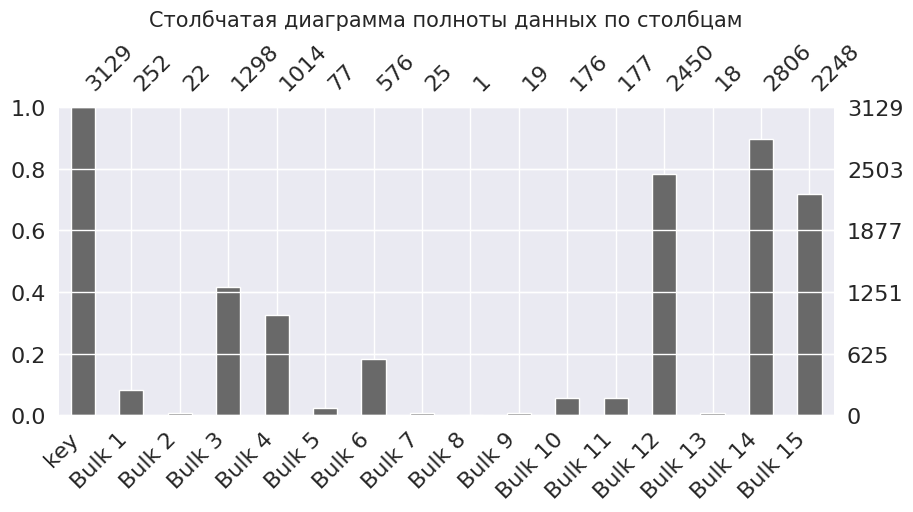

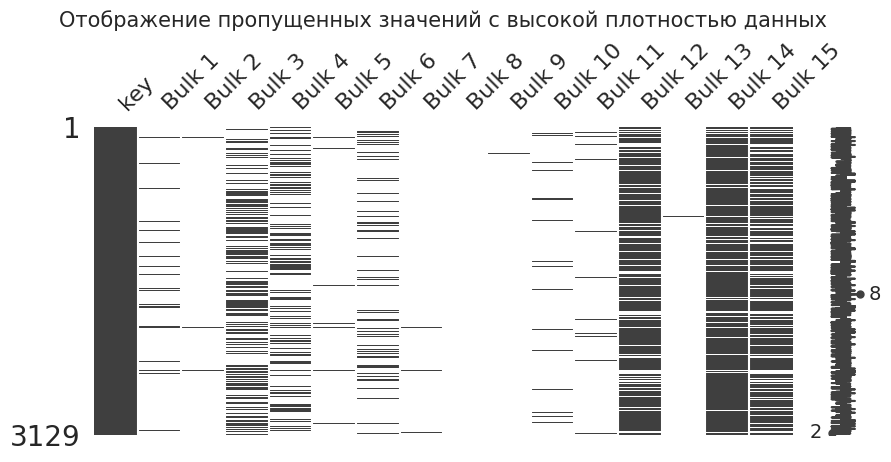

In [ ]:
get_data_info(data_bulk)

- в данных довольно большое число пропусков, которые, скорее всего, обусловлены отсутствием подаваемого материала в конкретное время;
- столбец `Bulk 8` почти не содержит значений, кроме одного - 49;
- в `Bulk 12` возможно наличие выбросов, так как максимальное значение для него составляет аж 1849, что сильно выбивается из общей картины, по распределению значений, мы посмотрим, стоит ли его изменять.

Позже пропуски мы можем заполнить нулевыми значениями, чтобы модели могли нормально работать.

#### 2.2.2.3 Анализ числовых переменных

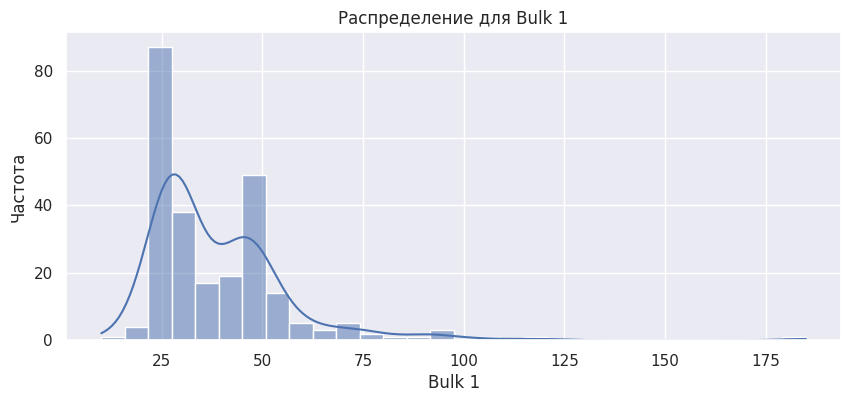

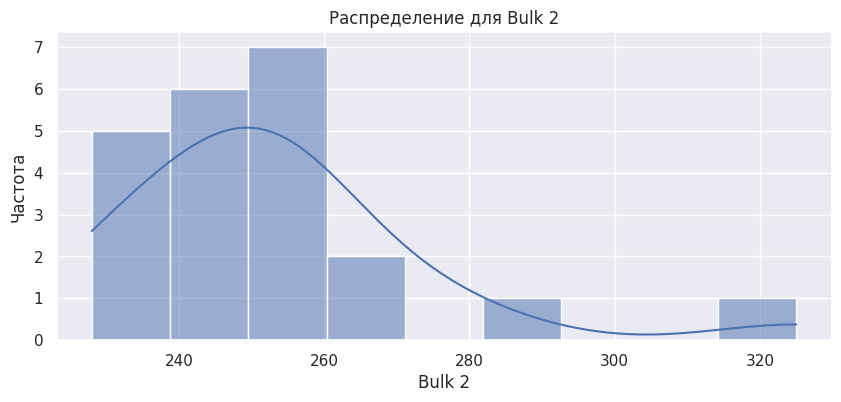

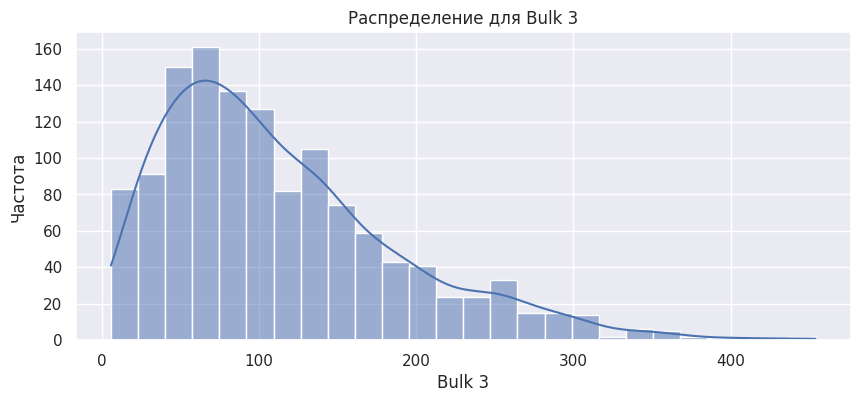

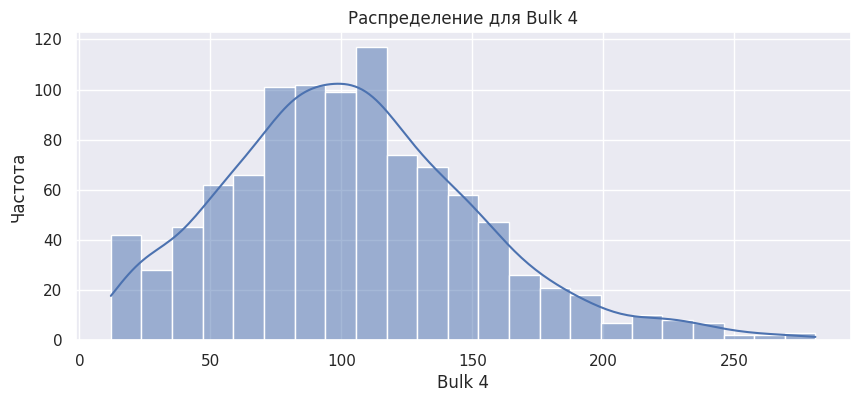

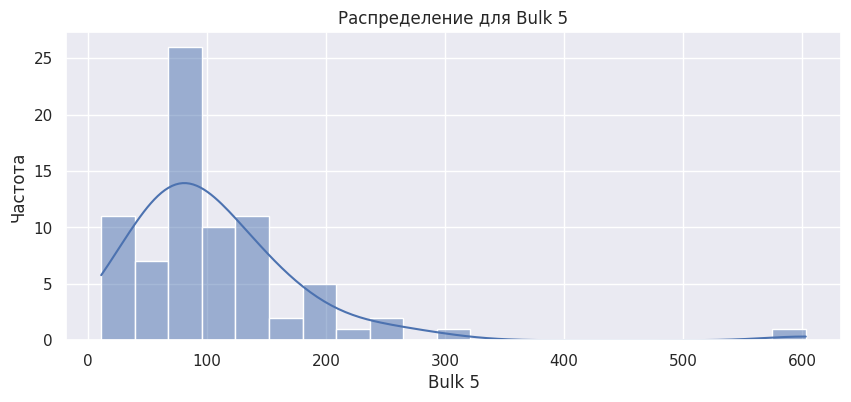

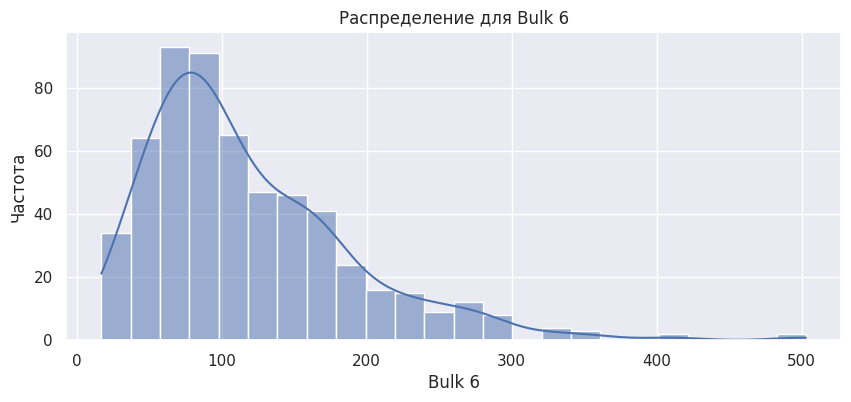

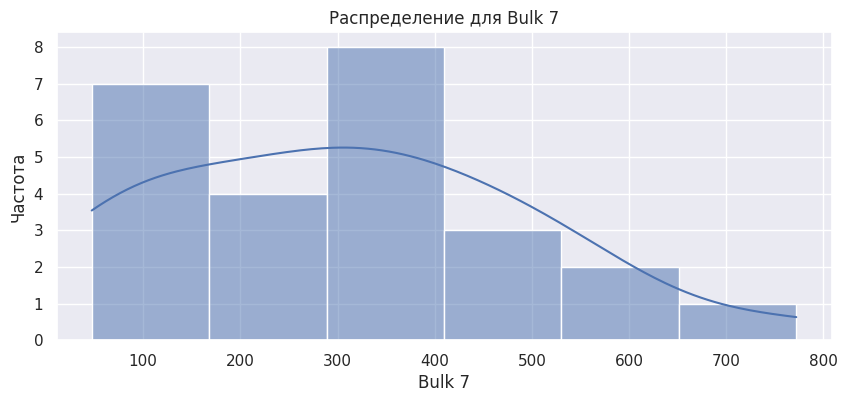

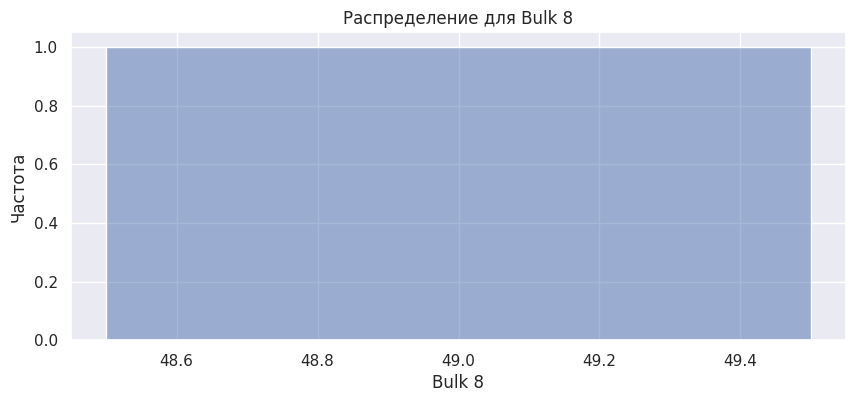

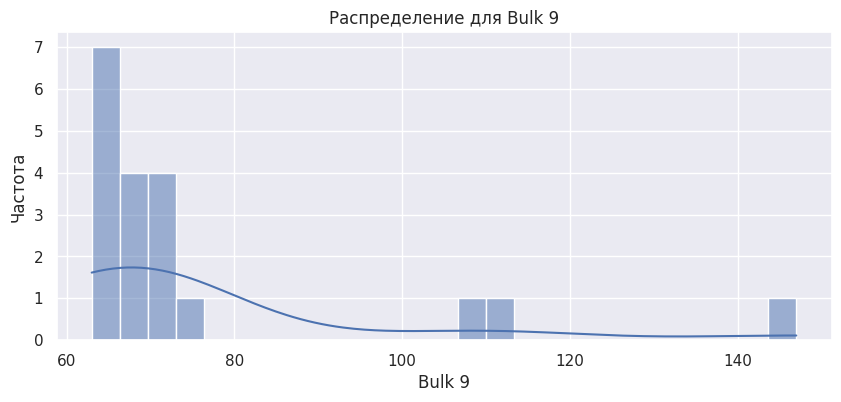

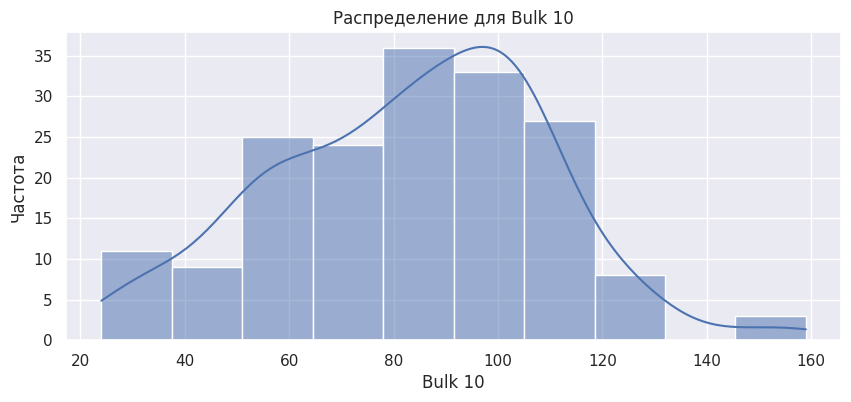

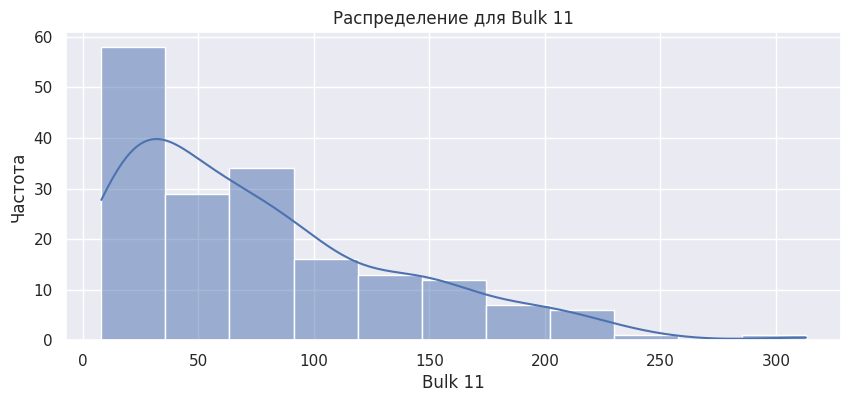

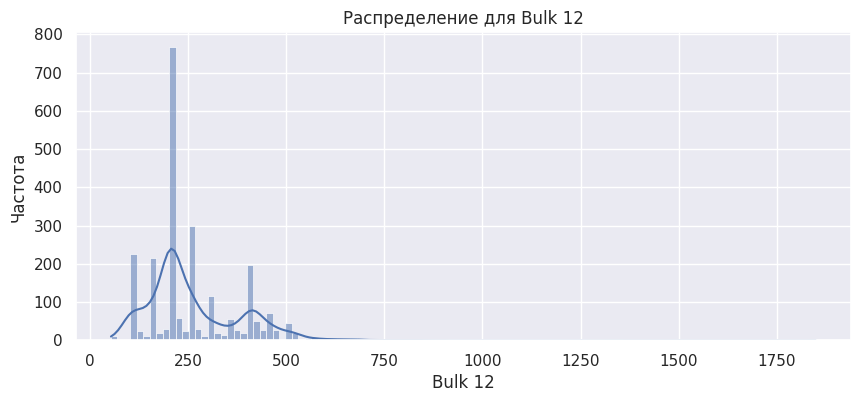

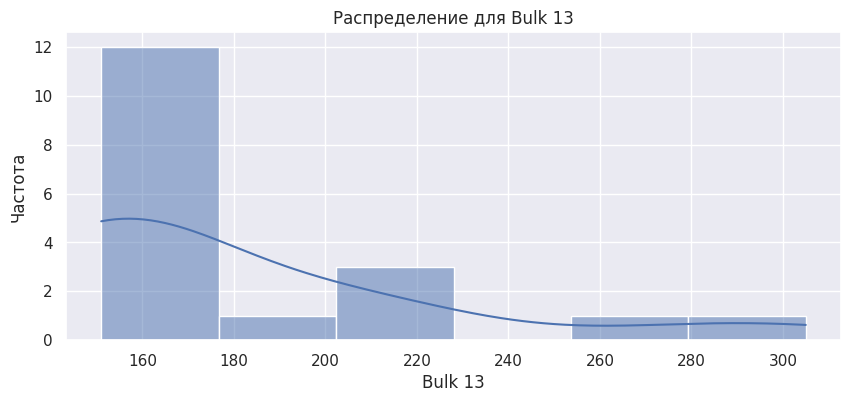

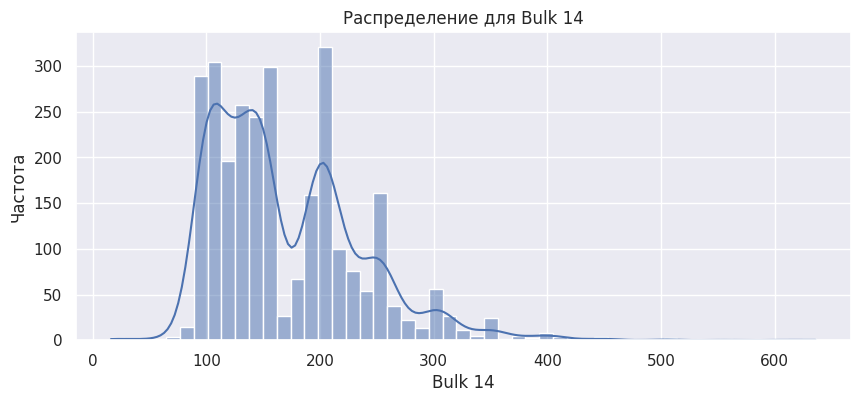

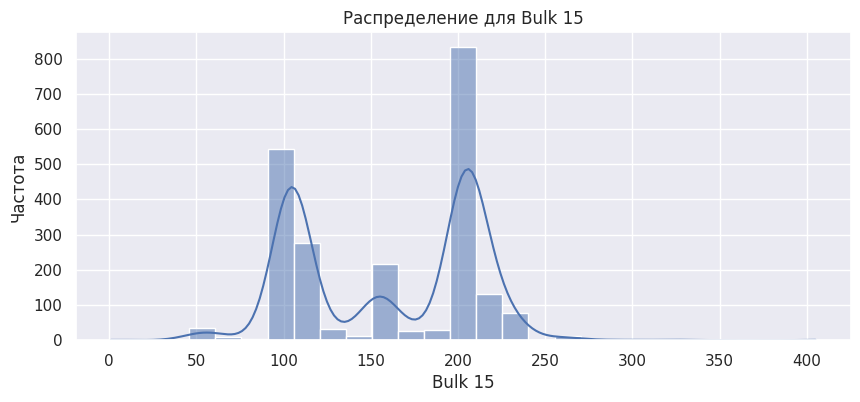

In [ ]:
plot_distributions(data_bulk, data_bulk.select_dtypes(include=['float64']).columns)

- Из картины распределений видно, что большинство стремится к гауссову распределению, однако каждая гистограмма имеет свои ярко-отличительные черты;

- В `Bulk 12` есть редкие выбросы, это видно по слишком затянутому правому концу.Аномалиями будем считать значения больше 1000. После данные выбросы мы приведем в медианному значению столбца. Мы не выбрали метод с просентилями, так как распределение у нашего столбца довольно уникальное, чтобы равнять его с другими распределениями. Плюс ко всему, в данной записи слишком много пропусков, чтобы корректно выполнить заполнение;

- Пропуски в данных будем приводить к нулю, т.е. сыпучий материал не подавался.

In [ ]:
print('Столбцы до обработки аномалий:')
display(data_bulk.loc[data_bulk['Bulk 12']>1000])

print('После:')
data_bulk.loc[data_bulk['Bulk 12']>1000, 'Bulk 12'] = data_bulk['Bulk 12'].quantile(0.5)
display(data_bulk.loc[data_bulk['Bulk 12']>1000])

Столбцы до обработки аномалий:


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
303  322   185.0     NaN   101.0    58.0     NaN     NaN   406.0     NaN   

     Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
303     NaN      NaN      NaN   1849.0      NaN    636.0      NaN

После:


Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

In [ ]:
print(f"Общее количество пропущенных значений в каждом столбце до заполнения пропусков:\n{data_bulk.isna().sum()}")

#сделаем копию необработанного датафрейма для будущего сравнения с таблицей временных меток data_bulk_time
data_bulk_copy = data_bulk.copy()

data_bulk.fillna(0, inplace=True)
display(HTML('<hr style="border:2px solid black; width:100%"/>'))
print(f"\nПосле:\n{data_bulk.isna().sum()}")

Общее количество пропущенных значений в каждом столбце до заполнения пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64



После:
key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64


#### 2.2.2.4 Проверка на отсутствие добавлений сыпучих материалов

Согласно технологиям, представленных заказчиком, в партию обязательно должны добавляться проволочные материалы. Поэтому проверим, есть ли такие партии, в которые данные материалы не добавлялись и после, если найдем, удалим.

In [ ]:
mask = (data_bulk.drop('key', axis=1) == 0).all(axis=1)
zero_rows = data_bulk.loc[mask]
display(zero_rows)

Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

### 2.2.3 Таблица `steel.data_bulk_time`

#### 2.2.3.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key Bulk 1 Bulk 2 Bulk 3    Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1   None   None   None  11:21:30   None   None   None   None   None   
1    2   None   None   None  11:46:38   None   None   None   None   None   
2    3   None   None   None  12:31:06   None   None   None   None   None   
3    4   None   None   None  12:48:43   None   None   None   None   None   
4    5   None   None   None  13:18:50   None   None   None   None   None   
5    6   None   None   None  13:59:24   None   None   None   None   None   
6    7   None   None   None  14:29:14   None   None   None   None   None   

  Bulk 10 Bulk 11   Bulk 12 Bulk 13   Bulk 14   Bulk 15  
0    None    None  11:03:52    None  11:03:52  11:03:52  
1    None    None  11:40:20    None  11:40:20  11:40:20  
2    None    None  12:09:40    None  12:09:40  12:09:40  
3    None    None  12:41:24    None  12:41:24  12:41:24  
4    None    None  13:12:56    None  13:12:56  13:12:56  
5    None    None  13:53:27    None  13:53:27  13:53:27  
6    None    None  14:22:19    None  14:22:19  14:22:19


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


Распределения значений в данных:



key    Bulk 1    Bulk 2    Bulk 3    Bulk 4    Bulk 5  \
count   3129.000000       252        22      1298      1014        77   
unique          NaN       252        22      1288      1009        77   
top             NaN  23:01:32  08:36:19  06:52:26  05:46:37  09:01:08   
freq            NaN         1         1         2         2         1   
mean    1624.383509       NaN       NaN       NaN       NaN       NaN   
std      933.337642       NaN       NaN       NaN       NaN       NaN   
min        1.000000       NaN       NaN       NaN       NaN       NaN   
25%      816.000000       NaN       NaN       NaN       NaN       NaN   
50%     1622.000000       NaN       NaN       NaN       NaN       NaN   
75%     2431.000000       NaN       NaN       NaN       NaN       NaN   
max     3241.000000       NaN       NaN       NaN       NaN       NaN   

          Bulk 6    Bulk 7    Bulk 8    Bulk 9   Bulk 10   Bulk 11   Bulk 12  \
count        576        25         1        19       176       177      2450   
unique       576        25         1        19       176       177      2407   
top     06:44:11  11:37:42  17:46:11  00:04:56  03:43:54  16:00:49  05:49:32   
freq           1         1         1         1         1         1         3   
mean         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
std          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
25%          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
50%          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
75%          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
max          NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         Bulk 13   Bulk 14   Bulk 15  
count         18      2806      2248  
unique        18      2760      2213  
top     00:39:35  05:49:32  05:49:32  
freq           1         3         3  
mean         NaN       NaN       NaN  
std          NaN       NaN       NaN  
min          NaN       NaN       NaN  
25%          NaN       NaN       NaN  
50%          NaN       NaN       NaN  
75%          NaN       NaN       NaN  
max          NaN       NaN       NaN

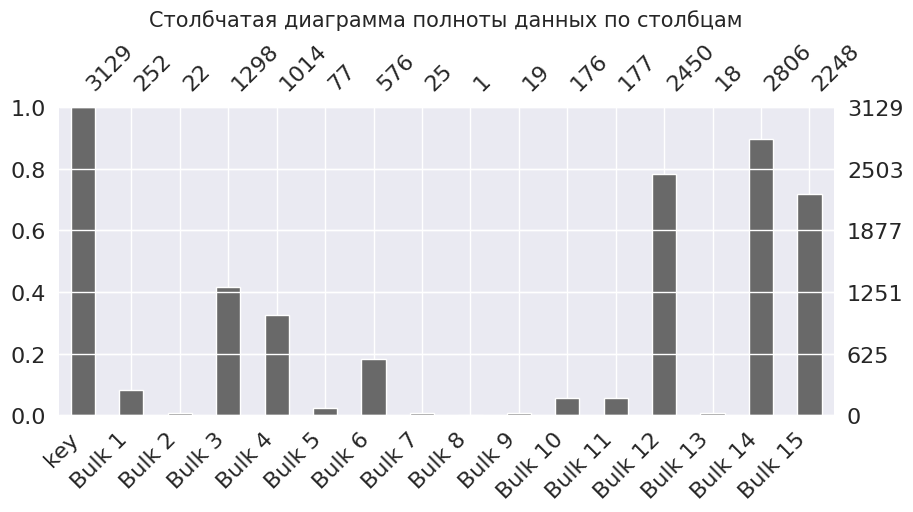

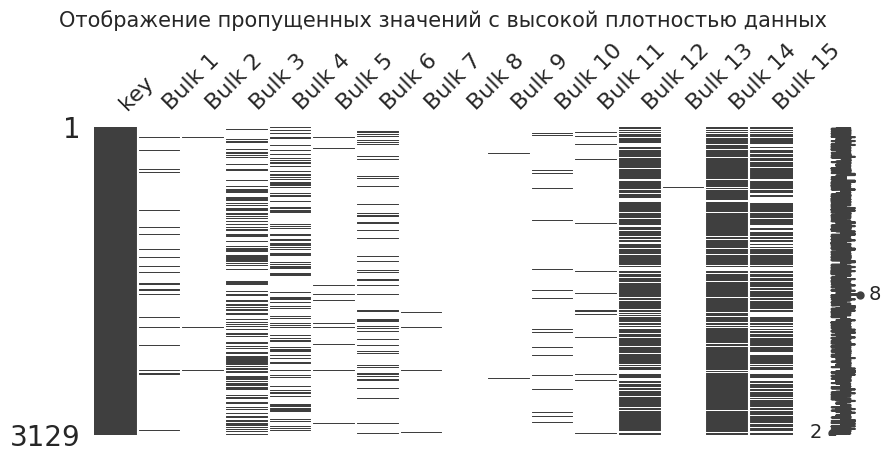

In [ ]:
get_data_info(data_bulk_time)

In [ ]:
print(f"Общее количество пропущенных значений в каждом столбце `data_bulk_time`:\n\n{data_bulk_time.isna().sum()}\n")
display(HTML('<hr style="border:2px solid black; width:100%"/>'))
print(f"Общее количество пропущенных значений в каждом столбце таблицы `data_bulk`:\n\n{data_bulk_copy.isna().sum()}\n")
del data_bulk_copy

Общее количество пропущенных значений в каждом столбце `data_bulk_time`:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64



Общее количество пропущенных значений в каждом столбце таблицы `data_bulk`:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64



Как мы видим, данная таблица содержит только время подачи сыпучих материалов аналогичные партиям в таблице `data_bulk`. Учитывая, что здесь есть пропуски, которые мы не сможем никак заполнить, а после вытащить из них какую-то агрегированную информацию, по типу разницей между подачами сыпчих песков, то использовать данную таблицу нам не имеет смысла, так как у нас не задача временных рядов.

### 2.2.4 Таблица `steel.data_gas`

#### 2.2.4.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Распределения значений в данных:



key          gas
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

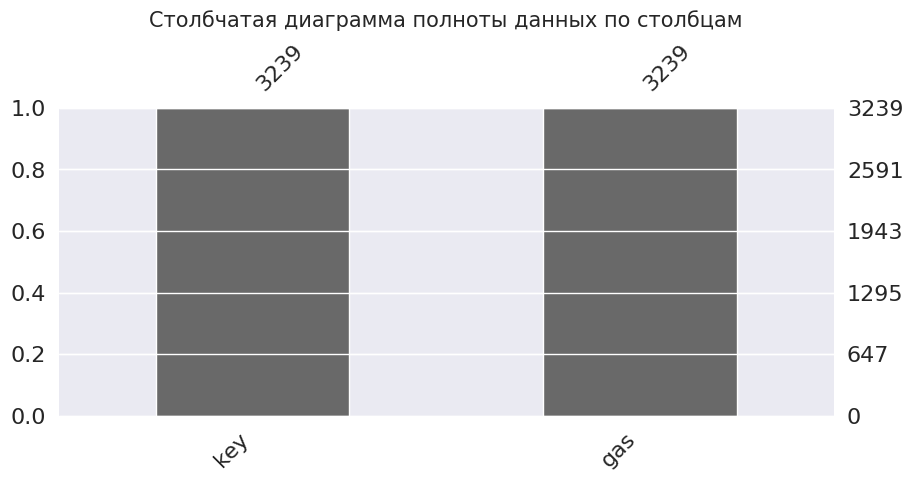

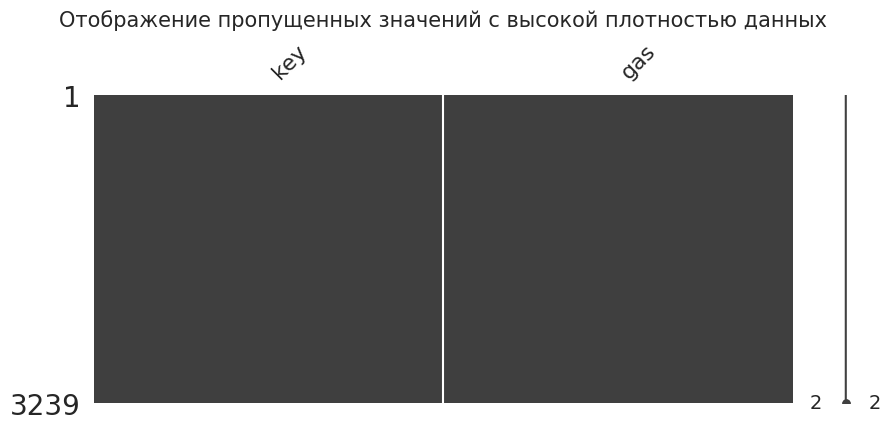

In [ ]:
get_data_info(data_gas)

- В наших данных пропусков обнаружено не было;
- Есть сомнения насчет наличия аномалий, так как максимальное значение в разы превосходит медианное, однако это будет виднее на графике распределения.

#### 2.2.4.2 Анализ числовых переменных

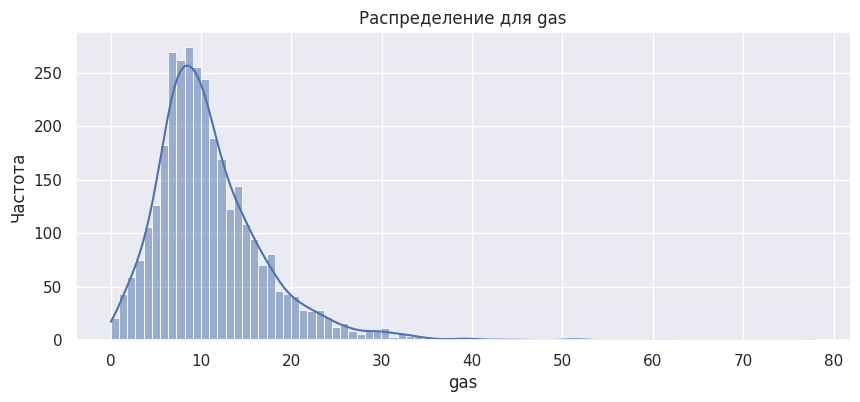

key        gas
116    117  50.581035
277    280  60.935689
319    322  77.995040
2107  2110  52.142373
2567  2570  51.380229

In [ ]:
plot_distributions(data_gas, data_gas.select_dtypes(include=['float64']).columns)
data_gas[data_gas['gas']>50]

Перед нами ярковыраженное нормальное распределение. Присутствуют несколько выбросов, однако они не сильно выбиваются из нашей картины, поэтому оставим их для лучшего качества модели.

### 2.2.5 Таблица `steel.data_temp`

#### 2.2.5.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:25:53       1604.0
2    1    11:29:11       1618.0
3    1    11:30:01       1601.0
4    1    11:30:39       1613.0
5    2    11:37:27       1581.0
6    2    11:38:00       1577.0


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


Распределения значений в данных:



key MesaureTime   Temperature
count   15907.000000       15907  13006.000000
unique           NaN       14558           NaN
top              NaN    20:51:33           NaN
freq             NaN           4           NaN
mean     1607.880870         NaN   1591.840920
std       942.212073         NaN     21.375851
min         1.000000         NaN   1191.000000
25%       790.000000         NaN   1581.000000
50%      1618.000000         NaN   1591.000000
75%      2427.000000         NaN   1601.000000
max      3241.000000         NaN   1705.000000

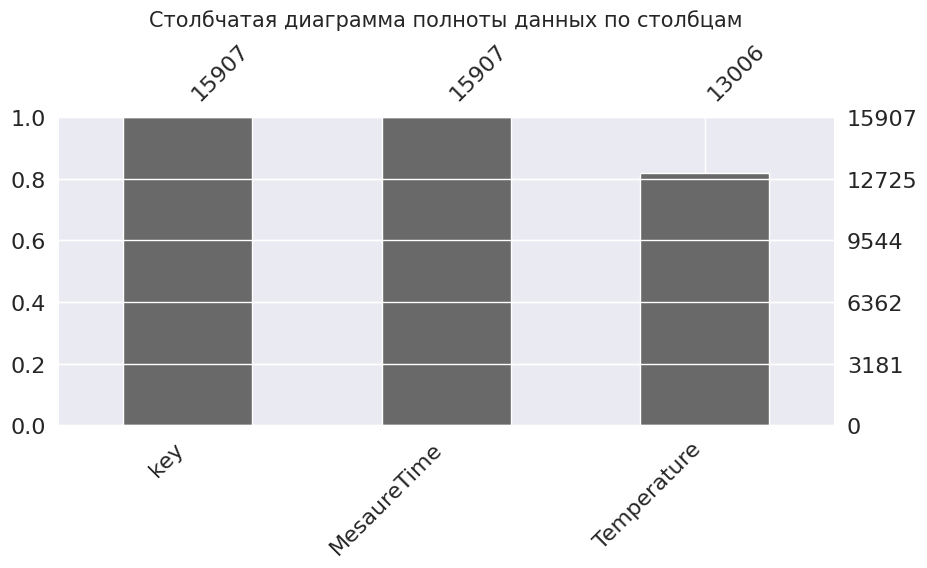

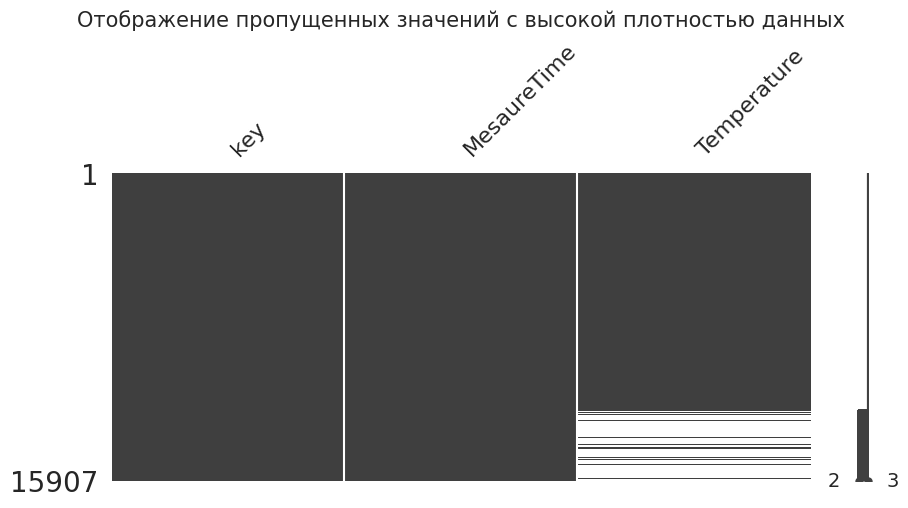

In [ ]:
get_data_info(data_temp)

- в данных присутствуют систематические пропуски среди последних записанных наблюдей, позже внимательнее рассмотрим этот случай
- согласно критерию заказчика, что температуры ниже 1500 - аномальные, нам следует удалить данные записи

In [ ]:
#удалим партии, у которых замер был лишь один раз
key_counts = data_temp['key'].value_counts()
keys = key_counts[key_counts == 1].index
print(f'Ключи, которые встречаются ровно один раз: {list(keys)}')

data_temp = data_temp.loc[~data_temp['key'].isin(keys)].reset_index(drop=True)
print(f'Данные ключи были удалены!')

Ключи, которые встречаются ровно один раз: [279, 195]
Данные ключи были удалены!


In [ ]:
data_temp.tail(20)

key MesaureTime  Temperature
15885  3239    01:42:46          NaN
15886  3239    01:48:00          NaN
15887  3239    01:59:27          NaN
15888  3239    02:13:30          NaN
15889  3239    02:22:15          NaN
15890  3239    02:23:02          NaN
15891  3239    02:24:15          NaN
15892  3240    02:39:01       1617.0
15893  3240    02:48:33          NaN
15894  3240    03:03:21          NaN
15895  3240    03:12:19          NaN
15896  3240    03:19:09          NaN
15897  3240    03:31:27          NaN
15898  3240    03:34:31          NaN
15899  3240    03:35:16          NaN
15900  3241    04:03:30       1586.0
15901  3241    04:16:12          NaN
15902  3241    04:22:39          NaN
15903  3241    04:33:42          NaN
15904  3241    04:38:08          NaN

Мы видим, что пропуски у нас появляются на самых поздних замерах, что бывают полностью незаписанные замеры, а бывают замеры для партий, которые единожды не нулевые, а после для этой партии идут пропуски.

Значит, поступим следующим образом:
1. Оставим партии, где первый и последний замер - непустые значения;
2. Удалим партии, где значения либо первого, либо последнего замеров менее 1500 градусов, данное решение следует из критерия заказчика.

Для начала создадим столбцы со стартовым и конечным временем замеров партии для всех записей, чтобы позже отрфильтровать нужные нам записи. Также проверим идут ли наши ключи партий в порядке возрастания, а время в каждой партии примем за возрастающее. Хотя в рабочей ситуации данные моменты лучше уточнять у заказчика.

Если проверка окажется успешной, то это сможет облегчить нам задачу преобразования таблицы.

In [ ]:
is_ordered = data_temp['key'].is_monotonic_increasing
print(f"Значения в столбце 'key' идут по порядку: {is_ordered}")

del is_ordered

Значения в столбце 'key' идут по порядку: True


In [ ]:
print('Начальная таблица: ')
display(data_temp.head())
display(HTML('<hr style="border:2px solid black; width:100%"/>'))

first_mesaure_times = data_temp.groupby('key')['MesaureTime'].first()
last_mesaure_times = data_temp.groupby('key')['MesaureTime'].last()

time_bounds = pd.DataFrame(
    {
        'FirstMesaureTime': first_mesaure_times,
        'LastMesaureTime': last_mesaure_times
    }
).reset_index()
#display(time_bounds.head())

data_temp = data_temp.merge(time_bounds, on='key')
#display(data_temp.head())

data_temp = data_temp[(data_temp['MesaureTime'] == data_temp['FirstMesaureTime']) | (data_temp['MesaureTime'] == data_temp['LastMesaureTime'])]
#display(data_temp.head())

#удаление вспомогательных столбцов и обновление индексов
data_temp = data_temp.drop(['FirstMesaureTime', 'LastMesaureTime'], axis=1).reset_index(drop=True)
print("Данные и отображение получившейся таблицы:")
display(data_temp.head(), data_temp.info())

Начальная таблица: 


key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:25:53       1604.0
2    1    11:29:11       1618.0
3    1    11:30:01       1601.0
4    1    11:30:39       1613.0

Данные и отображение получившейся таблицы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6428 entries, 0 to 6427
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          6428 non-null   int64  
 1   MesaureTime  6428 non-null   object 
 2   Temperature  5689 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 150.8+ KB


key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:30:39       1613.0
2    2    11:37:27       1581.0
3    2    11:59:12       1602.0
4    3    12:13:17       1596.0

None

#### 2.2.5.2 Анализ числовых переменных

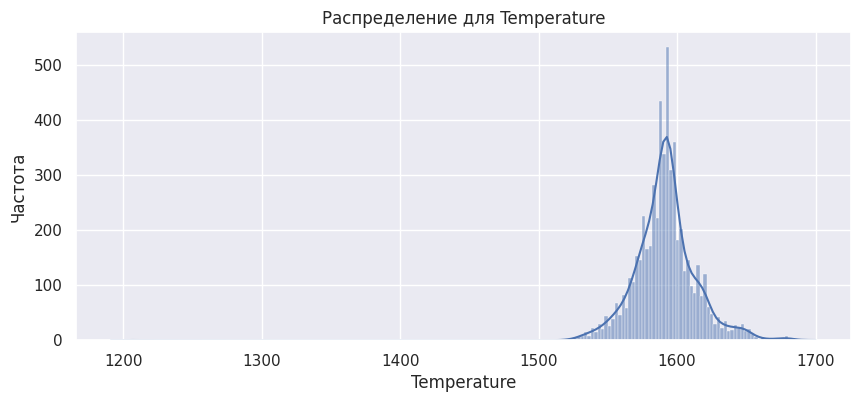

key MesaureTime  Temperature
1706   867    14:21:00       1191.0
2398  1214    05:32:00       1208.0
3204  1619    11:03:54       1218.0
4068  2052    14:51:40       1227.0
5072  2561    07:34:15       1204.0

In [ ]:
plot_distributions(data_temp, data_temp.select_dtypes(include=['float64']).columns)
data_temp[data_temp['Temperature']<1500]

- Распределение наших температур близко к нормальному;
- Необходимо удалить партии в которых есть аномально низкие значения или есть пропуски в первом или последних замерах.

In [ ]:
#удаление партий с пустыми значениями
keys = list(data_temp[data_temp['Temperature'].isna()]['key'])
print(keys[:10])
data_temp = data_temp.loc[~data_temp['key'].isin(keys)]

[2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509]


In [ ]:
#удалим аномальные партии
keys = list(data_temp[data_temp['Temperature']<1500]['key'])
print(f'Аномальные партии: {keys}')

#также обновим индексы
data_temp = data_temp.loc[~data_temp['key'].isin(keys)].reset_index(drop=True)
display(data_temp.tail(7))

Аномальные партии: [867, 1214, 1619, 2052]


key MesaureTime  Temperature
4935  2496    01:29:52       1591.0
4936  2497    01:41:53       1571.0
4937  2497    01:53:50       1589.0
4938  2498    02:03:49       1591.0
4939  2498    02:25:31       1594.0
4940  2499    02:40:25       1569.0
4941  2499    03:00:28       1603.0

#### 2.2.5.3 Агрегирование таблицы и добавление признаков

In [ ]:
display(data_temp.head(10), data_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          4942 non-null   int64  
 1   MesaureTime  4942 non-null   object 
 2   Temperature  4942 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 116.0+ KB


key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:30:39       1613.0
2    2    11:37:27       1581.0
3    2    11:59:12       1602.0
4    3    12:13:17       1596.0
5    3    12:34:57       1599.0
6    4    12:52:57       1601.0
7    4    12:59:25       1625.0
8    5    13:23:19       1576.0
9    5    13:36:01       1602.0

None

In [ ]:
#создадим два df, один с начальными замерами, другой с конечными
start_measurements = data_temp.groupby('key').first().reset_index().rename(columns={'MesaureTime': 'MesaureTime_start', 'Temperature': 'Temperature_start'})
end_measurements = data_temp.groupby('key').last().reset_index().rename(columns={'MesaureTime': 'MesaureTime_final', 'Temperature': 'Temperature_final'})

#объединим начальные и конечные замеры
data_temp = pd.merge(start_measurements, end_measurements, on='key')

display(data_temp.head(), data_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2471 non-null   int64  
 1   MesaureTime_start  2471 non-null   object 
 2   Temperature_start  2471 non-null   float64
 3   MesaureTime_final  2471 non-null   object 
 4   Temperature_final  2471 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 96.6+ KB


key MesaureTime_start  Temperature_start MesaureTime_final  \
0    1          11:16:18             1571.0          11:30:39   
1    2          11:37:27             1581.0          11:59:12   
2    3          12:13:17             1596.0          12:34:57   
3    4          12:52:57             1601.0          12:59:25   
4    5          13:23:19             1576.0          13:36:01   

   Temperature_final  
0             1613.0  
1             1602.0  
2             1599.0  
3             1625.0  
4             1602.0

None

Агрегация прошла успешно, это видно по уменьшившимуся ровно в два раза финальному версии датасета, а также по первым 10 преобразованным записям.

Далее создадим синтетическую переменную, равную разнице конечного времени и начального. И после вычислим разницу в секнудах.

In [ ]:
data_temp['TimeDifference'] = calculate_time_difference(data_temp, 'MesaureTime_start', 'MesaureTime_final')

#преобразование разницы во времени в различные форматы
data_temp['TimeDifference_hours'] = data_temp['TimeDifference'].apply(lambda x: x.seconds // 3600)
data_temp['TimeDifference_minutes'] = data_temp['TimeDifference'].apply(lambda x: (x.seconds % 3600) // 60)
data_temp['TimeDifference_seconds'] = data_temp['TimeDifference'].apply(lambda x: x.seconds % 60)
data_temp['TimeDifference_seconds_total'] = data_temp['TimeDifference'].apply(lambda x: x.total_seconds())

#чек результатов
display(data_temp[['MesaureTime_start', 'MesaureTime_final', 'TimeDifference', 'TimeDifference_hours', 'TimeDifference_minutes', 'TimeDifference_seconds', 'TimeDifference_seconds_total']])


MesaureTime_start MesaureTime_final  TimeDifference  \
0             11:16:18          11:30:39 0 days 00:14:21   
1             11:37:27          11:59:12 0 days 00:21:45   
2             12:13:17          12:34:57 0 days 00:21:40   
3             12:52:57          12:59:25 0 days 00:06:28   
4             13:23:19          13:36:01 0 days 00:12:42   
...                ...               ...             ...   
2466          00:35:45          00:54:42 0 days 00:18:57   
2467          01:02:54          01:29:52 0 days 00:26:58   
2468          01:41:53          01:53:50 0 days 00:11:57   
2469          02:03:49          02:25:31 0 days 00:21:42   
2470          02:40:25          03:00:28 0 days 00:20:03   

      TimeDifference_hours  TimeDifference_minutes  TimeDifference_seconds  \
0                        0                      14                      21   
1                        0                      21                      45   
2                        0                      21                      40   
3                        0                       6                      28   
4                        0                      12                      42   
...                    ...                     ...                     ...   
2466                     0                      18                      57   
2467                     0                      26                      58   
2468                     0                      11                      57   
2469                     0                      21                      42   
2470                     0                      20                       3   

      TimeDifference_seconds_total  
0                            861.0  
1                           1305.0  
2                           1300.0  
3                            388.0  
4                            762.0  
...                            ...  
2466                        1137.0  
2467                        1618.0  
2468                         717.0  
2469                        1302.0  
2470                        1203.0  

[2471 rows x 7 columns]

### 2.2.6 Таблица `steel.data_wire`

#### 2.2.6.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   
5    6  99.109917  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   
6    7  98.061600      NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Распределения значений в данных:



key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060484    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

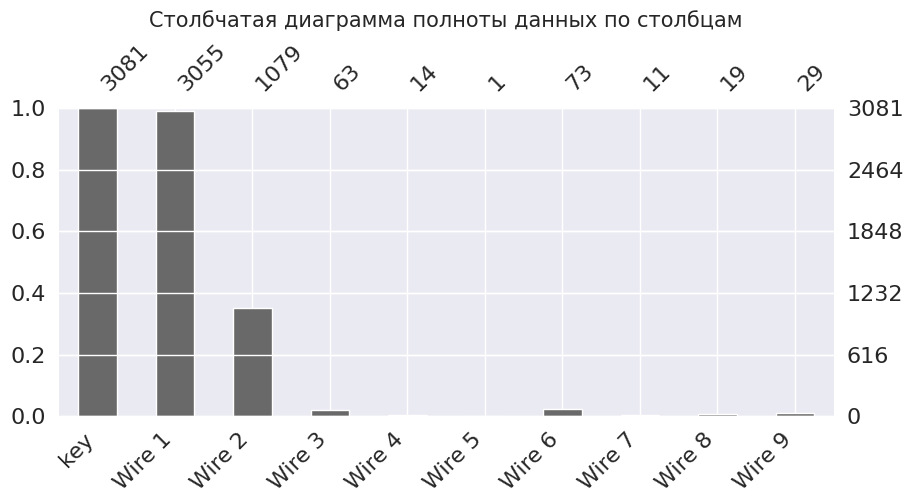

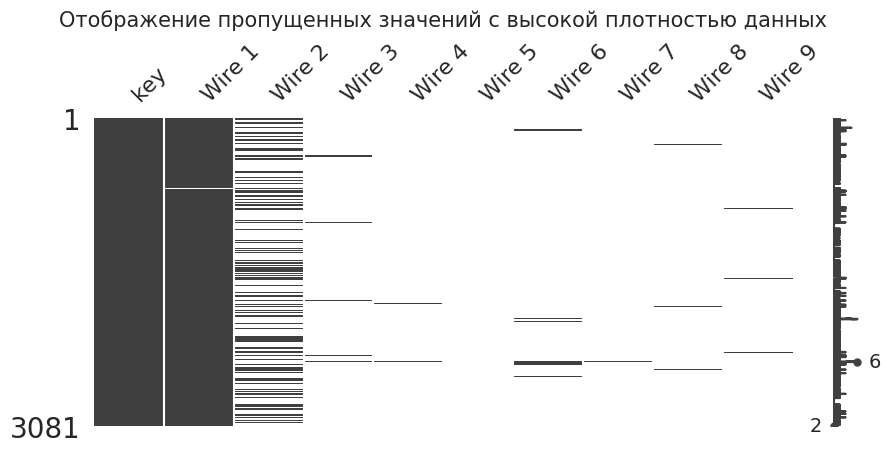

In [ ]:
get_data_info(data_wire)

Все пропуски мы заполним нулями, так как это соответствует недобавлению материала, что было сообщено нам заказачиком.

Также число записей в таблице соответствует числу уникальных `key` в данной таблице.

In [ ]:
print(f"Общее количество пропущенных значений в каждом столбце до заполнения пропусков:\n\n{data_wire.isna().sum()}\n")
data_wire_copy = data_wire.copy()
data_wire.fillna(0, inplace=True)

display(HTML('<hr style="border:2px solid black; width:100%"/>'))
print(f"После:\n\n{data_wire.isna().sum()}")

Общее количество пропущенных значений в каждом столбце до заполнения пропусков:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64



После:

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64


#### 2.2.6.2 Проверка на отсутствие добавлений проволочных материалов

Согласно технологиям, представленных заказчиком, в партию обязательно должны добавляться проволочные материалы. Поэтому проверим, есть ли такие партии, в которые данные материалы не добавлялись и после, если найдем, удалим.

In [ ]:
mask = (data_wire.drop('key', axis=1) == 0).all(axis=1)
zero_rows = data_wire.loc[mask]
display(zero_rows)

Empty DataFrame
Columns: [key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9]
Index: []

### 2.2.7 Таблица `steel.data_wire_time`

#### 2.2.7.1 Общий взгляд на данные

Вывод некоторых записей из датафрейма:



key    Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  11:11:41      None   None   None   None   None   None   None   None
1    2  11:46:10      None   None   None   None   None   None   None   None
2    3  12:13:47      None   None   None   None   None   None   None   None
3    4  12:48:05      None   None   None   None   None   None   None   None
4    5  13:18:15  13:32:06   None   None   None   None   None   None   None
5    6  13:59:02  13:59:54   None   None   None   None   None   None   None
6    7  14:28:46      None   None   None   None   None   None   None   None


Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Распределения значений в данных:



key    Wire 1    Wire 2    Wire 3    Wire 4    Wire 5  \
count   3081.000000      3055      1079        63        14         1   
unique          NaN      3000      1075        63        14         1   
top             NaN  11:15:01  21:37:29  04:47:53  08:48:23  16:01:07   
freq            NaN         2         2         1         1         1   
mean    1623.426485       NaN       NaN       NaN       NaN       NaN   
std      932.996726       NaN       NaN       NaN       NaN       NaN   
min        1.000000       NaN       NaN       NaN       NaN       NaN   
25%      823.000000       NaN       NaN       NaN       NaN       NaN   
50%     1619.000000       NaN       NaN       NaN       NaN       NaN   
75%     2434.000000       NaN       NaN       NaN       NaN       NaN   
max     3241.000000       NaN       NaN       NaN       NaN       NaN   

          Wire 6    Wire 7    Wire 8    Wire 9  
count         73        11        19        29  
unique        73        11        19        29  
top     00:59:11  12:42:00  00:03:32  16:09:11  
freq           1         1         1         1  
mean         NaN       NaN       NaN       NaN  
std          NaN       NaN       NaN       NaN  
min          NaN       NaN       NaN       NaN  
25%          NaN       NaN       NaN       NaN  
50%          NaN       NaN       NaN       NaN  
75%          NaN       NaN       NaN       NaN  
max          NaN       NaN       NaN       NaN

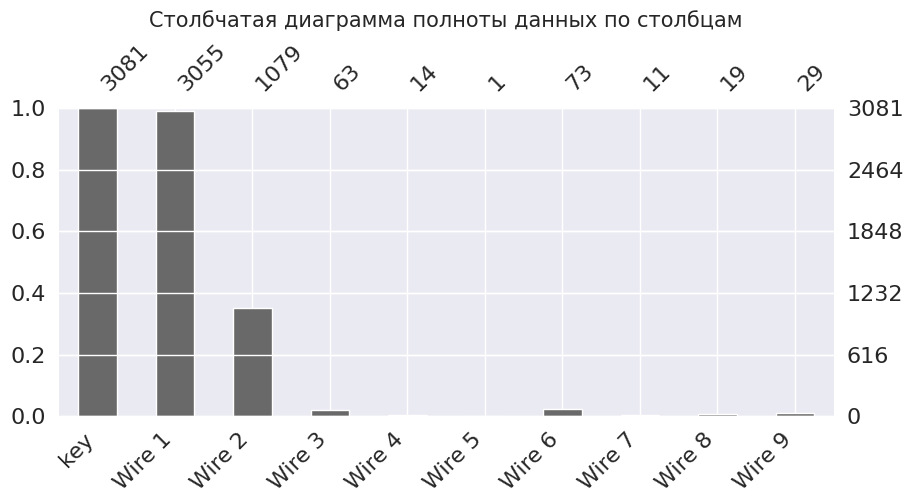

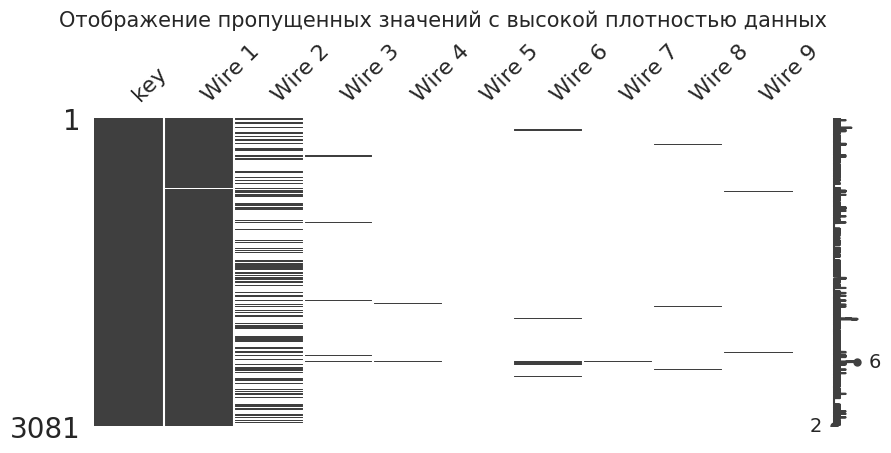

In [ ]:
get_data_info(data_wire_time)

In [ ]:
print(f"Общее количество пропущенных значений в каждом столбце `data_wire_time`:\n\n{data_wire_time.isna().sum()}\n")
display(HTML('<hr style="border:2px solid black; width:100%"/>'))
print(f"Общее количество пропущенных значений в каждом столбце таблицы `data_wire`:\n\n{data_wire_copy.isna().sum()}\n")
del data_wire_copy

Общее количество пропущенных значений в каждом столбце `data_wire_time`:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64



Общее количество пропущенных значений в каждом столбце таблицы `data_wire`:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64



Как мы видим данная таблица содержит исключительно временные метки аналогичные партиям из таблицы `data_wire` так как у нас нет возможности грамотно заполнить данные пропуски, и плюс перед нами задача не временных рядов, то данную таблицу мы не будем использовать для обучения модели.

### 2.2.8 Объединение таблиц по ключу

Произведем объединение всех таблиц по ключу `key` методом `inner`, так как если у партии не было одного из процессов (т.е. данной партии нет в одной из таблиц), то данная партия не соответствует технологическому процессу и её стоит удалить в результирующей таблице.

In [ ]:
#датафреймы, которые мы будем объединять
dataframes = [result, data_bulk, data_gas, data_temp, data_wire]

#функция для объединения всех DataFrame в один
def merge_dfs(df_list, key, join_method='inner'):
    return reduce(lambda left, right: pd.merge(left, right, on=key, how=join_method), df_list)

#объединение всех DataFrame
merged_df = merge_dfs(dataframes, 'key', 'inner')
display(merged_df.head(7))

key  ActivePower  ReactivePower  HeatingTime_minutes  HeatingTime_seconds  \
0    1     0.975629       0.636648                  3.0                 28.0   
1    2     0.763150       0.499528                  2.5                 23.5   
2    3     0.505176       0.319815                  1.0                 17.0   
3    4     0.802313       0.515074                  2.5                 37.5   
4    5     0.836793       0.563161                  3.0                 11.5   
5    6     0.988777       0.672294                  3.0                 40.5   
6    7     0.636844       0.390324                  1.0                 48.0   

   HeatingTime_seconds_total_median  HeatingTime_seconds_total  TotalPower  \
0                             185.0                     1098.0    1.165279   
1                             173.5                      811.0    0.912304   
2                             109.0                      655.0    0.597907   
3                             182.0                      741.0    0.953741   
4                             191.5                      869.0    1.008939   
5                             225.5                      952.0    1.196709   
6                             108.5                      673.0    0.746944   

   TotalPower^2  PowerRatio  ...  TimeDifference_seconds_total     Wire 1  \
0      1.536349    1.538898  ...                         861.0  60.059998   
1      1.008996    1.551834  ...                        1305.0  96.052315   
2      0.476228    1.583120  ...                        1300.0  91.160157   
3      1.027082    1.563487  ...                         388.0  89.063515   
4      1.395051    1.480428  ...                         762.0  89.238236   
5      1.809124    1.501854  ...                        1385.0  99.109917   
6      0.829024    1.628748  ...                        1374.0  98.061600   

    Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
0  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4  9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5  9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
6  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[7 rows x 54 columns]

По условию нам необходимо, чтобы одной партии соответствовало одно наблюдение, поэтому проверим число записец в нашей таблице и число уникальных ключей (номеров партий).

In [ ]:
#проверим число уникальных партий в столбце с ключами
unique_keys_count = merged_df['key'].nunique()
print(f"Число уникальных значений в столбце 'key': {unique_keys_count}")
print(f"Число записей в таблице: {merged_df.shape[0]}")

Число уникальных значений в столбце 'key': 2325
Число записей в таблице: 2325


Объединение фреймов произведено корректно.

Далее посмотрим на столбцы и типы данных, содержащиеся в них.

In [ ]:
display(merged_df.columns)

Index(['key', 'ActivePower', 'ReactivePower', 'HeatingTime_minutes',
       'HeatingTime_seconds', 'HeatingTime_seconds_total_median',
       'HeatingTime_seconds_total', 'TotalPower', 'TotalPower^2', 'PowerRatio',
       'PowerRatio^2', 'TotalEnergy', 'ActivePower^2', 'ReactivePower^2',
       'log_ActivePower', 'log_ReactivePower', 'log_TotalPower',
       'log_TotalEnergy', 'multiplication_Powers', 'NumberOfLaunches',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'gas', 'MesaureTime_start', 'Temperature_start',
       'MesaureTime_final', 'Temperature_final', 'TimeDifference',
       'TimeDifference_hours', 'TimeDifference_minutes',
       'TimeDifference_seconds', 'TimeDifference_seconds_total', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9'],
      dtype='object')

В нашем датафрейме присутствуют "мусорные признаки" со временем, а именно `MesaureTime_start`, `MesaureTime_final`, `TimeDifference`. Их нужно удалить, так как они никак не смогут далее помочь с обучением, потому что модели не смогут их корректно обработать.

Также сделаем номер партии индексом.


In [ ]:
merged_df = merged_df.drop(columns=['MesaureTime_start', 'MesaureTime_final', 'TimeDifference'])
merged_df.set_index('key', inplace=True, drop=True)

display(merged_df.head(7), merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 1 to 2499
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ActivePower                       2325 non-null   float64
 1   ReactivePower                     2325 non-null   float64
 2   HeatingTime_minutes               2325 non-null   float64
 3   HeatingTime_seconds               2325 non-null   float64
 4   HeatingTime_seconds_total_median  2325 non-null   float64
 5   HeatingTime_seconds_total         2325 non-null   float64
 6   TotalPower                        2325 non-null   float64
 7   TotalPower^2                      2325 non-null   float64
 8   PowerRatio                        2325 non-null   float64
 9   PowerRatio^2                      2325 non-null   float64
 10  TotalEnergy                       2325 non-null   float64
 11  ActivePower^2                     2325 non-null   float64
 12  ReactivePow

ActivePower  ReactivePower  HeatingTime_minutes  HeatingTime_seconds  \
key                                                                         
1       0.975629       0.636648                  3.0                 28.0   
2       0.763150       0.499528                  2.5                 23.5   
3       0.505176       0.319815                  1.0                 17.0   
4       0.802313       0.515074                  2.5                 37.5   
5       0.836793       0.563161                  3.0                 11.5   
6       0.988777       0.672294                  3.0                 40.5   
7       0.636844       0.390324                  1.0                 48.0   

     HeatingTime_seconds_total_median  HeatingTime_seconds_total  TotalPower  \
key                                                                            
1                               185.0                     1098.0    1.165279   
2                               173.5                      811.0    0.912304   
3                               109.0                      655.0    0.597907   
4                               182.0                      741.0    0.953741   
5                               191.5                      869.0    1.008939   
6                               225.5                      952.0    1.196709   
7                               108.5                      673.0    0.746944   

     TotalPower^2  PowerRatio  PowerRatio^2  ...  \
key                                          ...   
1        1.536349    1.538898      2.375090  ...   
2        1.008996    1.551834      2.412047  ...   
3        0.476228    1.583120      2.506611  ...   
4        1.027082    1.563487      2.451143  ...   
5        1.395051    1.480428      2.196144  ...   
6        1.809124    1.501854      2.268948  ...   
7        0.829024    1.628748      2.652925  ...   

     TimeDifference_seconds_total     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  \
key                                                                             
1                           861.0  60.059998  0.00000     0.0     0.0     0.0   
2                          1305.0  96.052315  0.00000     0.0     0.0     0.0   
3                          1300.0  91.160157  0.00000     0.0     0.0     0.0   
4                           388.0  89.063515  0.00000     0.0     0.0     0.0   
5                           762.0  89.238236  9.11456     0.0     0.0     0.0   
6                          1385.0  99.109917  9.11456     0.0     0.0     0.0   
7                          1374.0  98.061600  0.00000     0.0     0.0     0.0   

     Wire 6  Wire 7  Wire 8  Wire 9  
key                                  
1       0.0     0.0     0.0     0.0  
2       0.0     0.0     0.0     0.0  
3       0.0     0.0     0.0     0.0  
4       0.0     0.0     0.0     0.0  
5       0.0     0.0     0.0     0.0  
6       0.0     0.0     0.0     0.0  
7       0.0     0.0     0.0     0.0  

[7 rows x 50 columns]

None

### 2.2.9 Анализ признаков объединенной таблицы

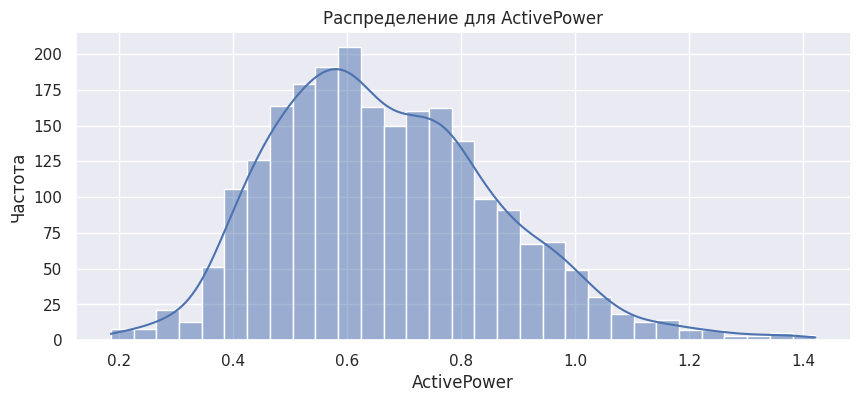

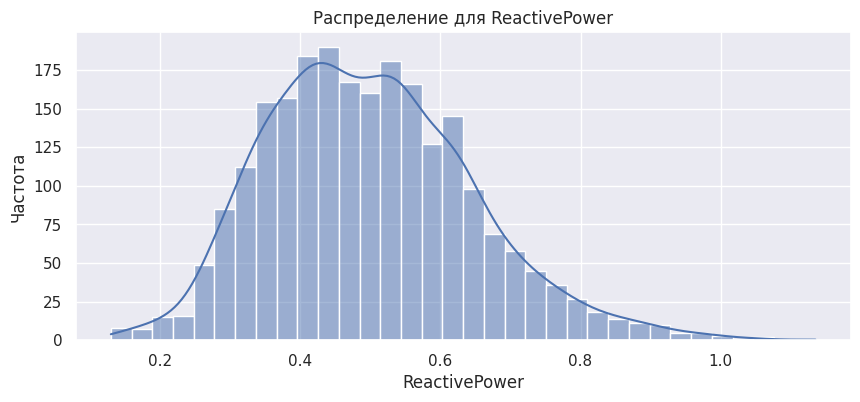

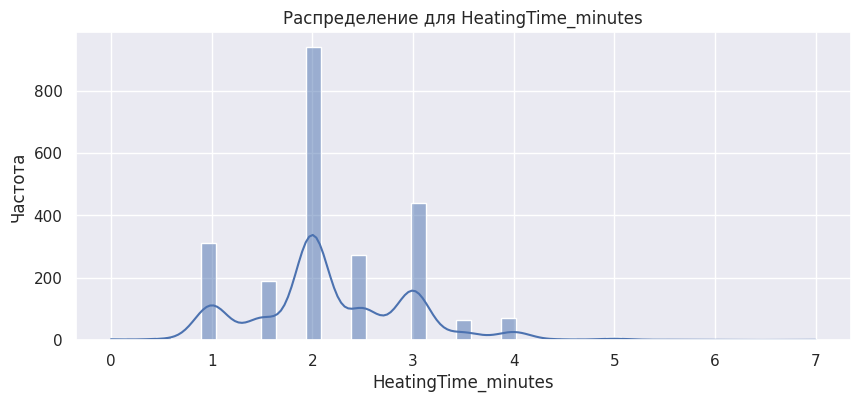

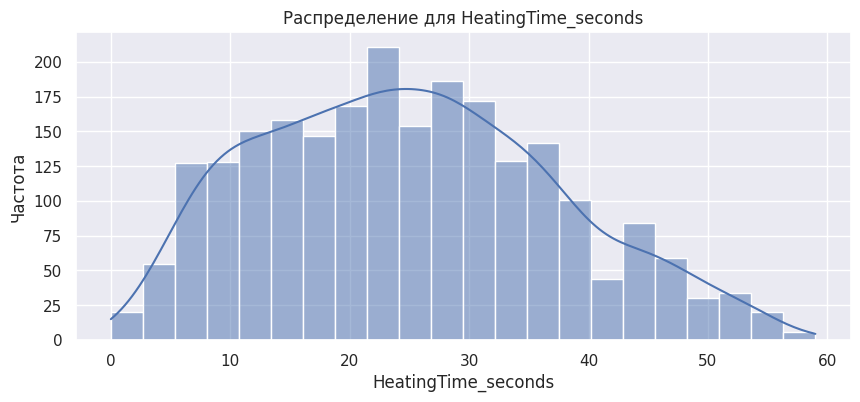

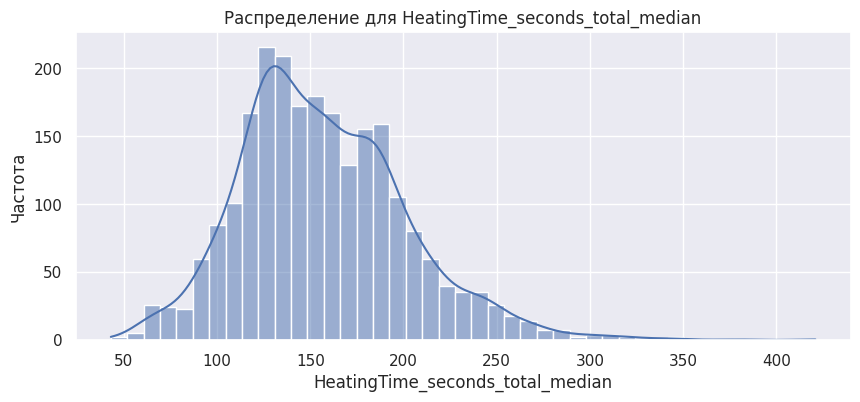

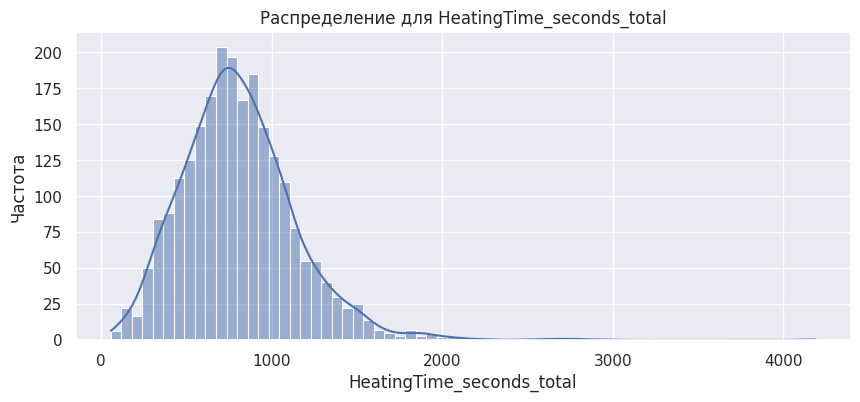

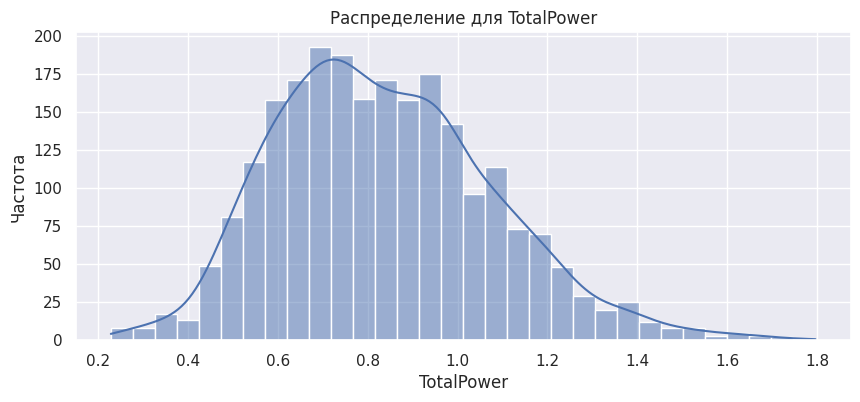

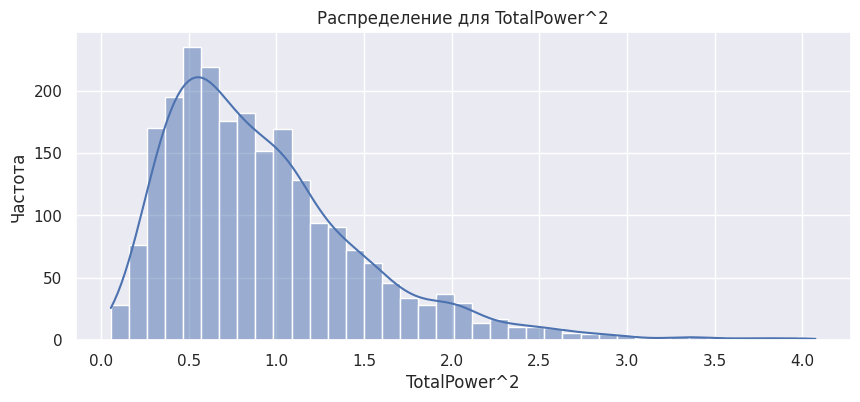

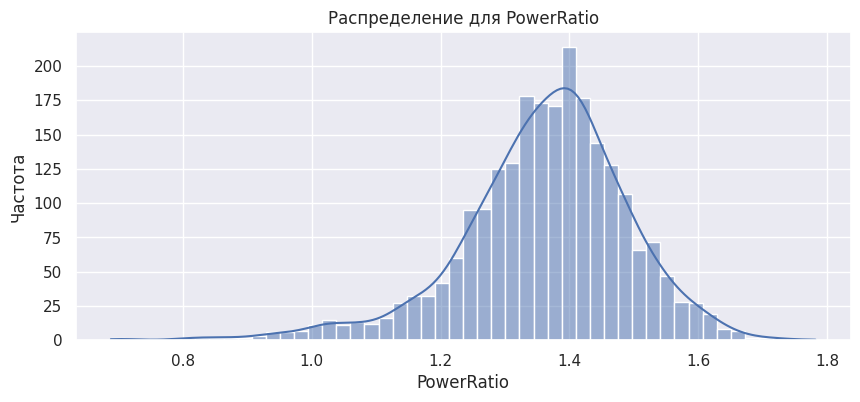

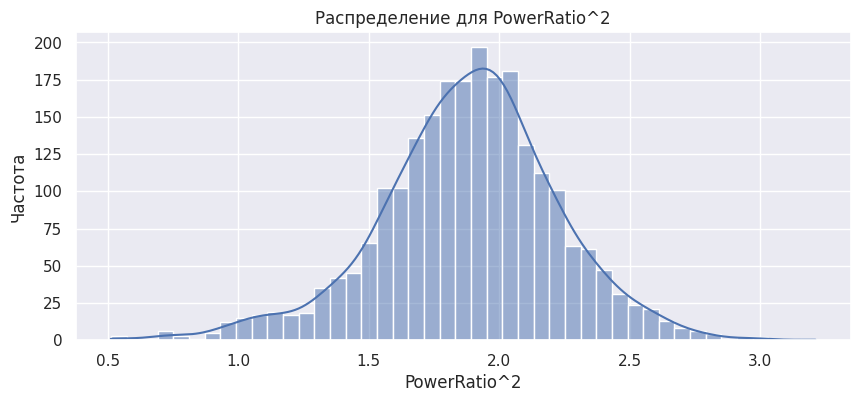

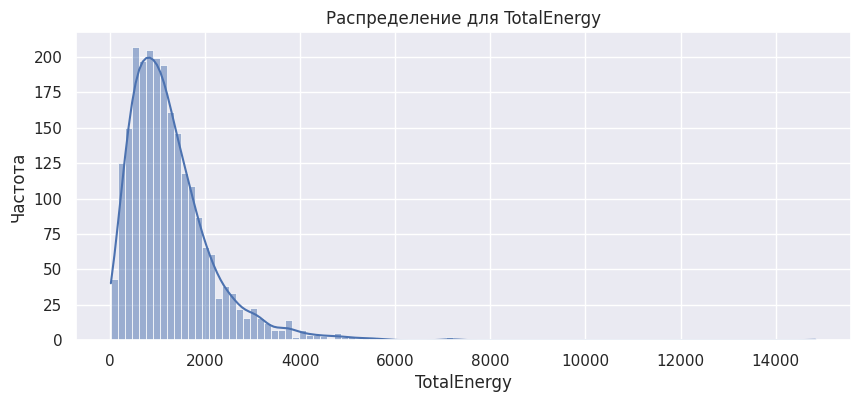

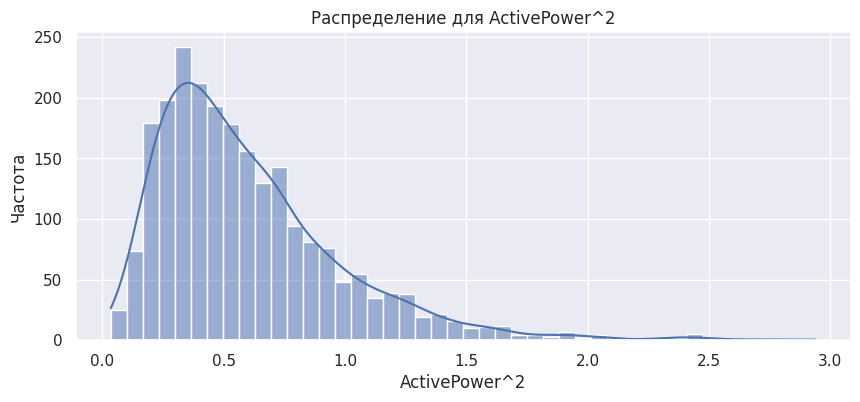

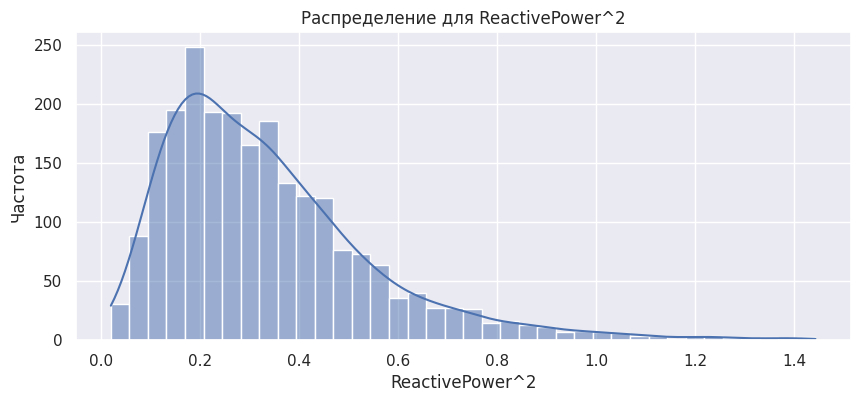

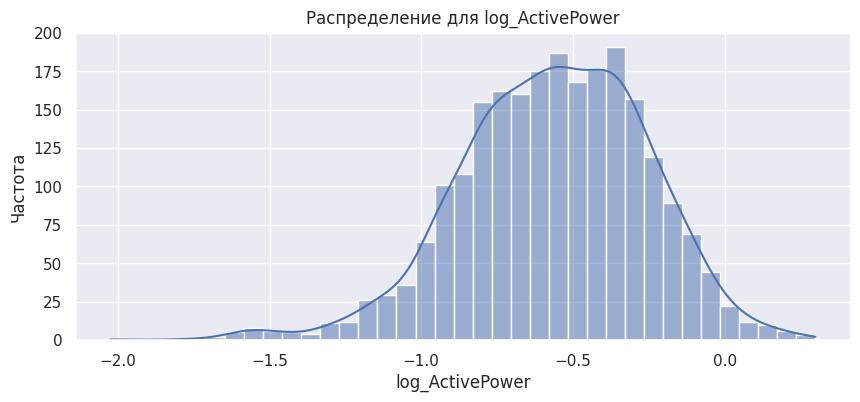

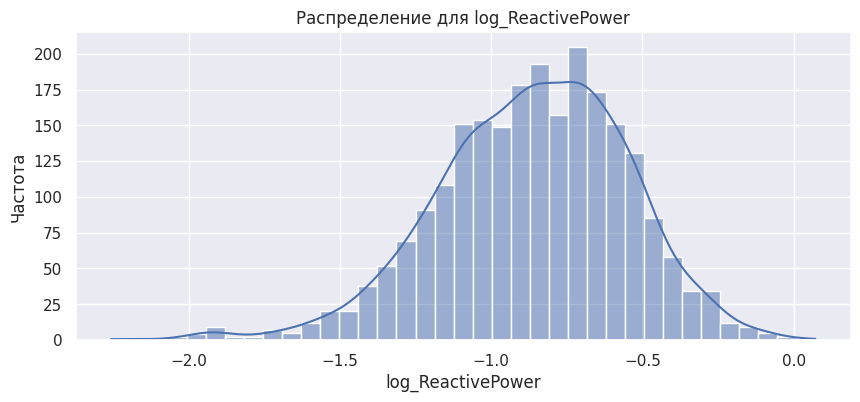

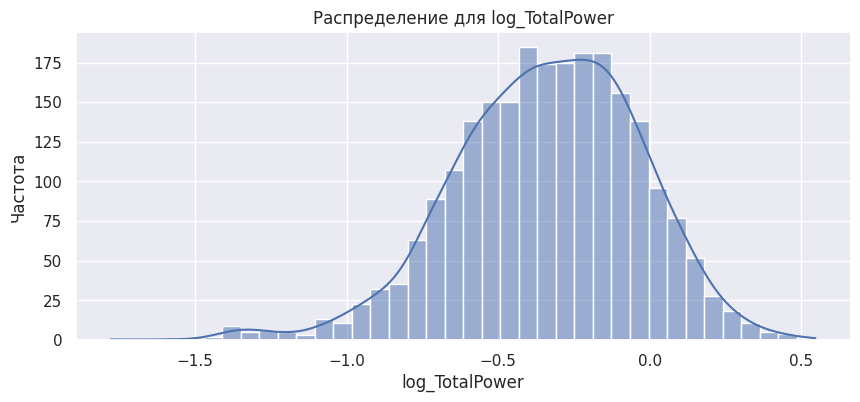

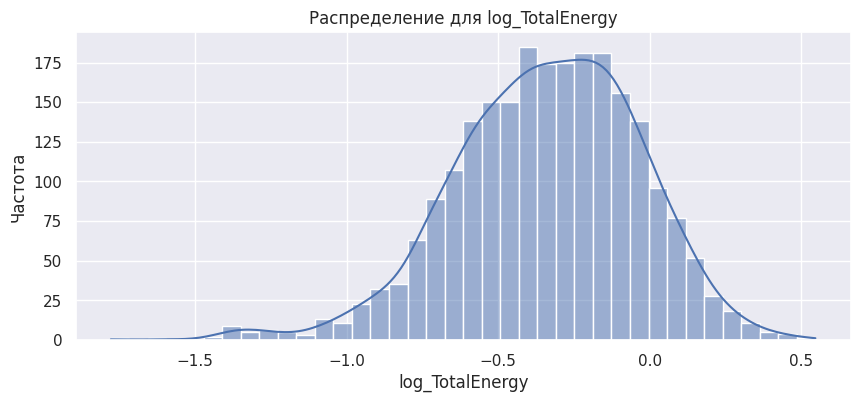

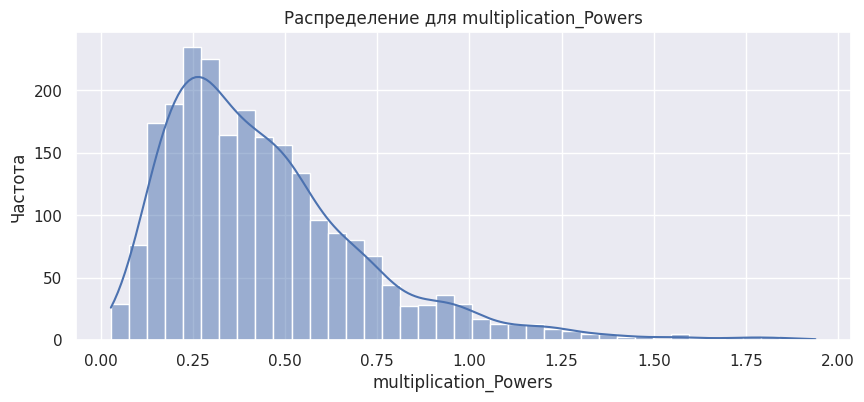

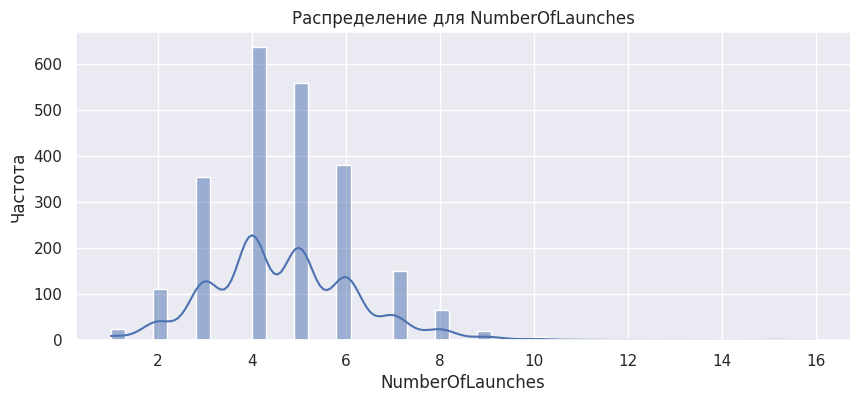

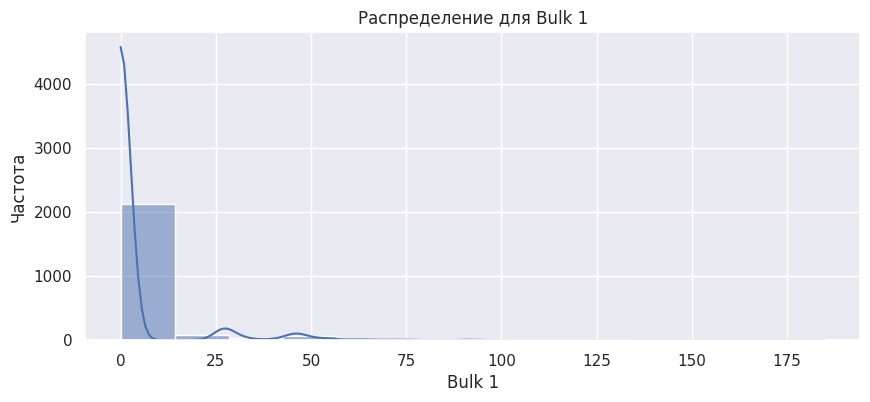

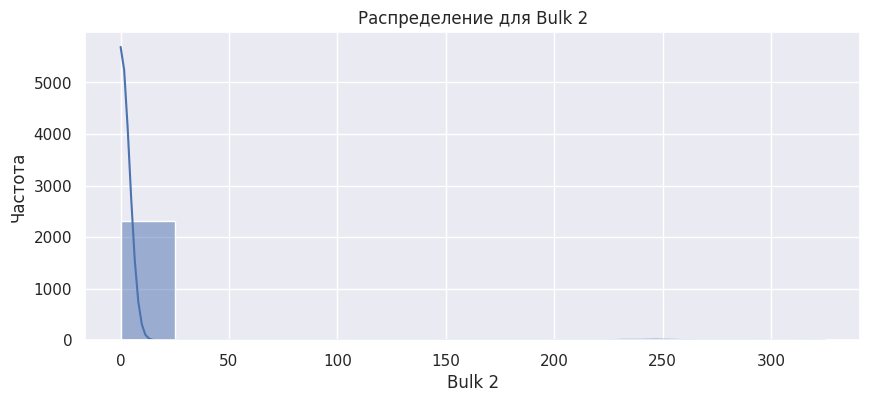

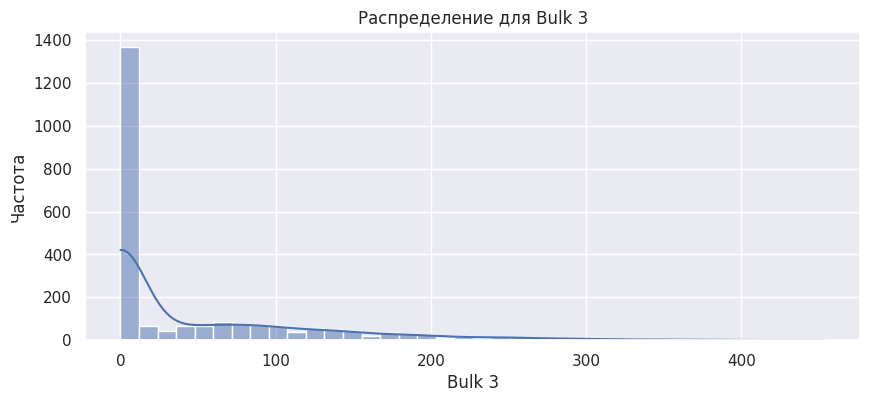

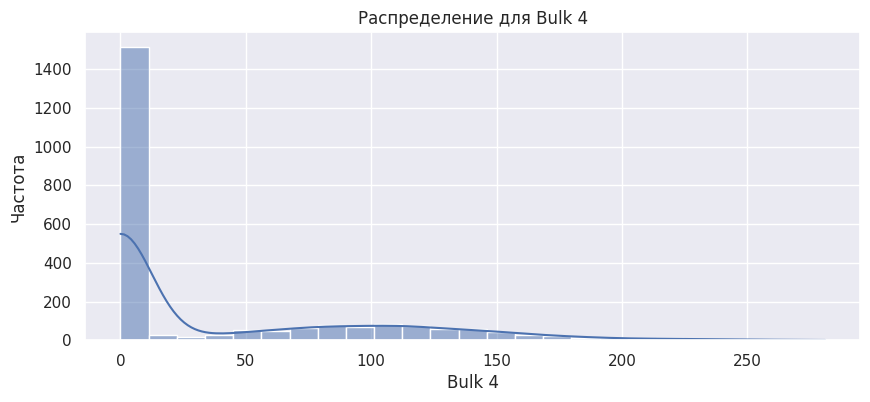

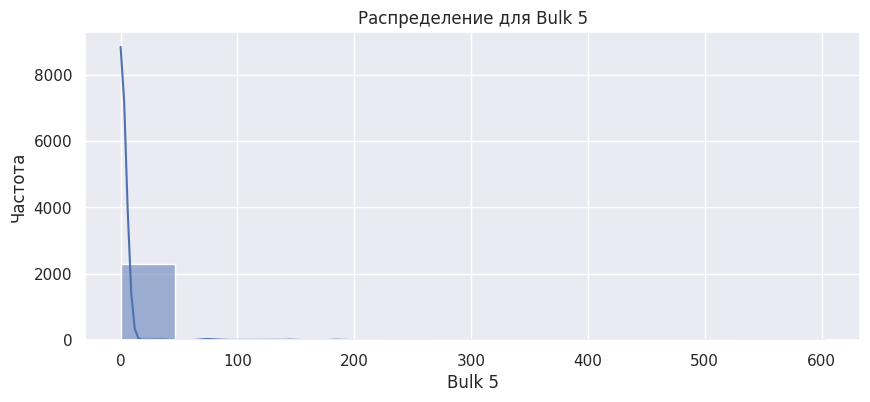

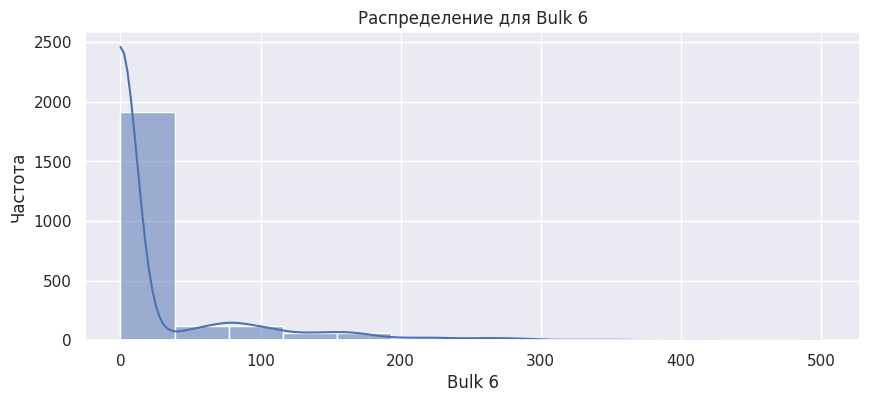

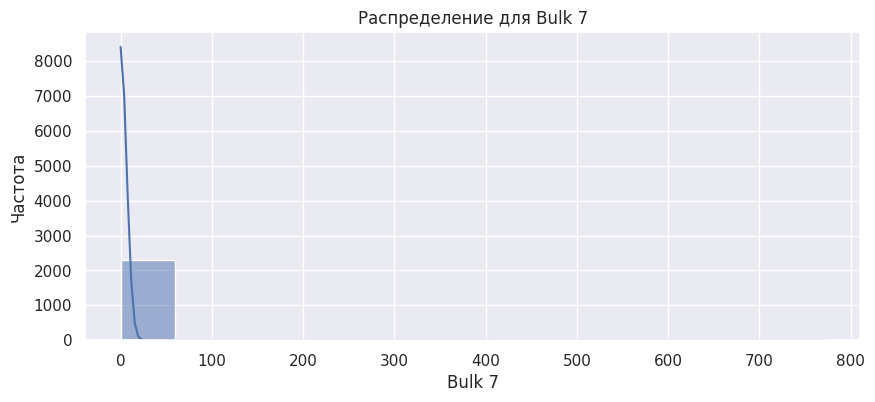

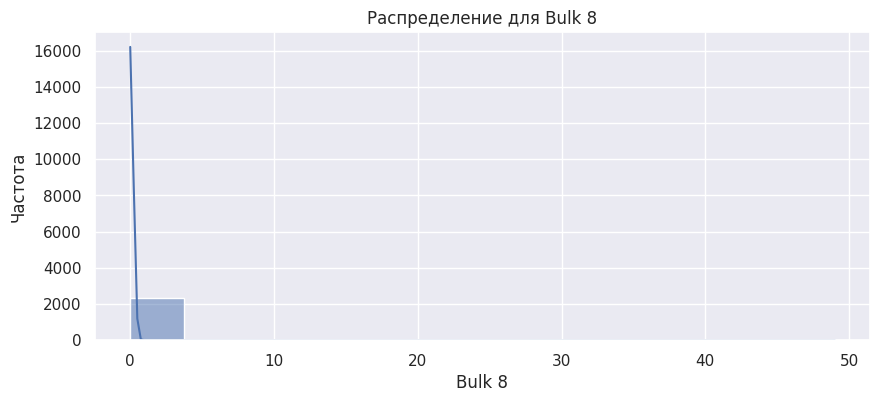

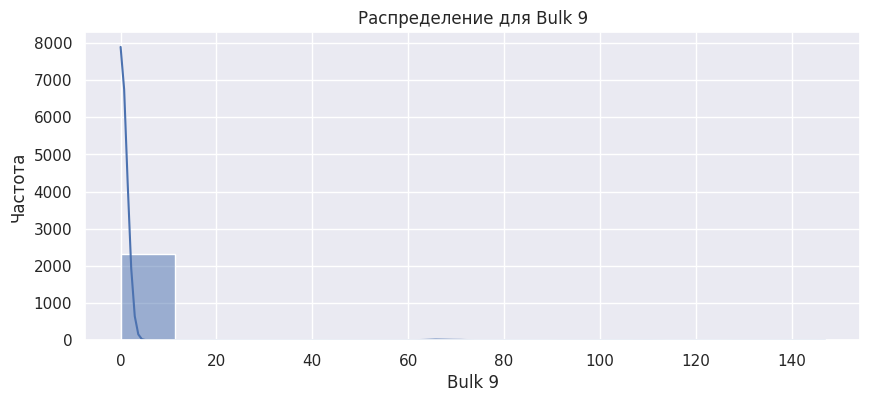

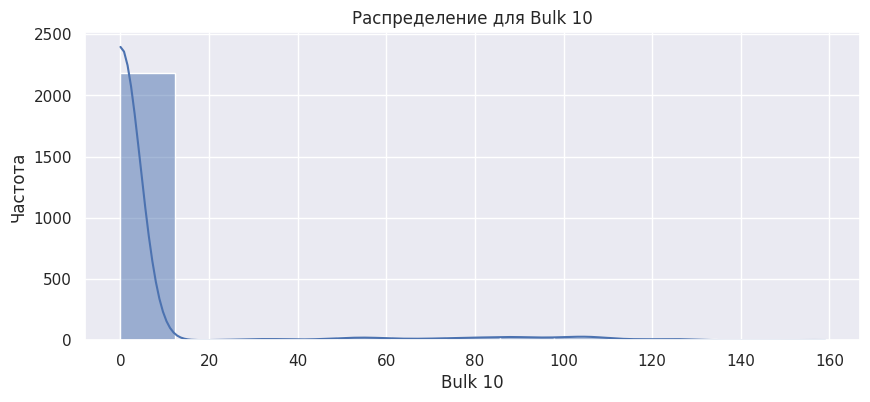

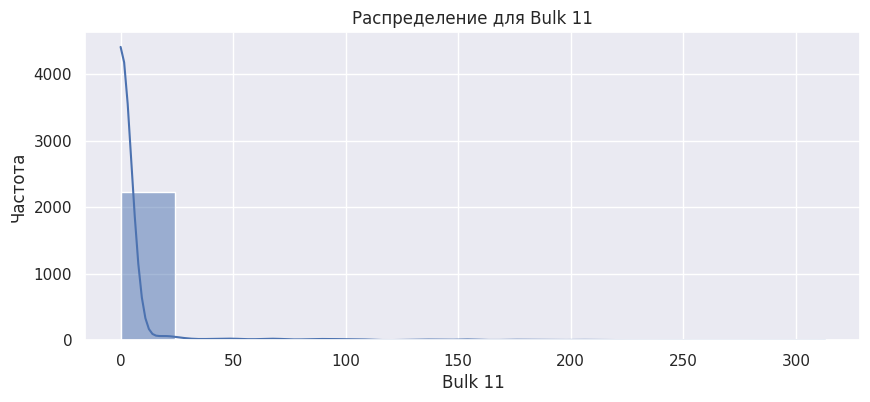

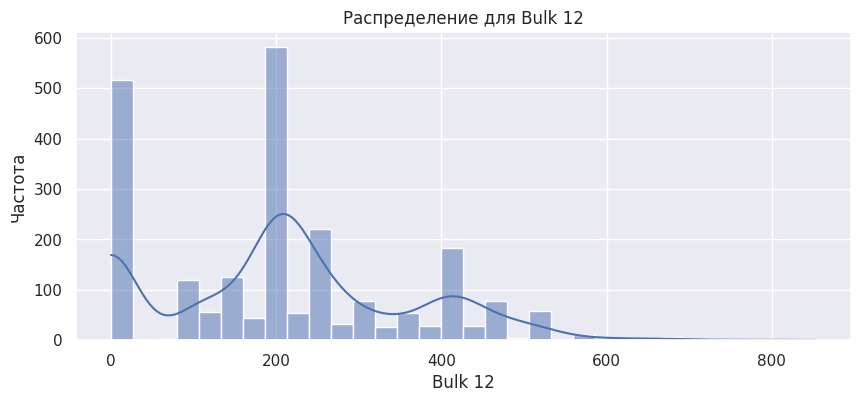

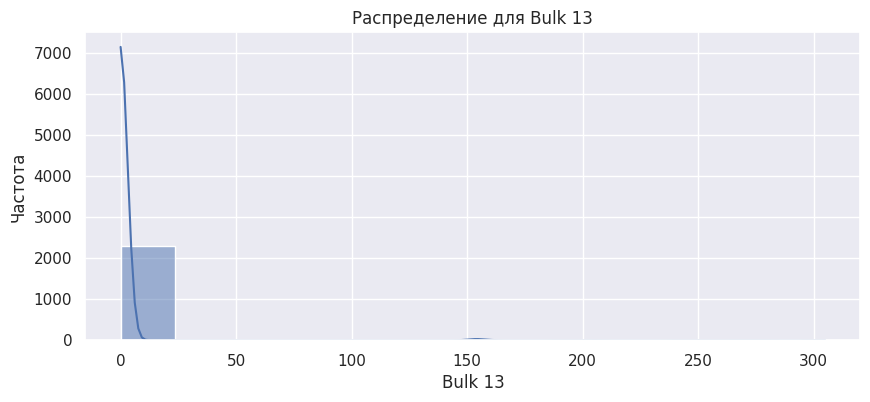

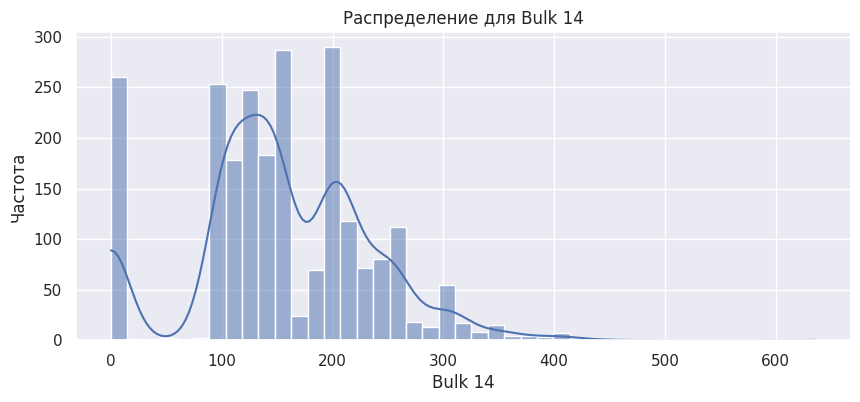

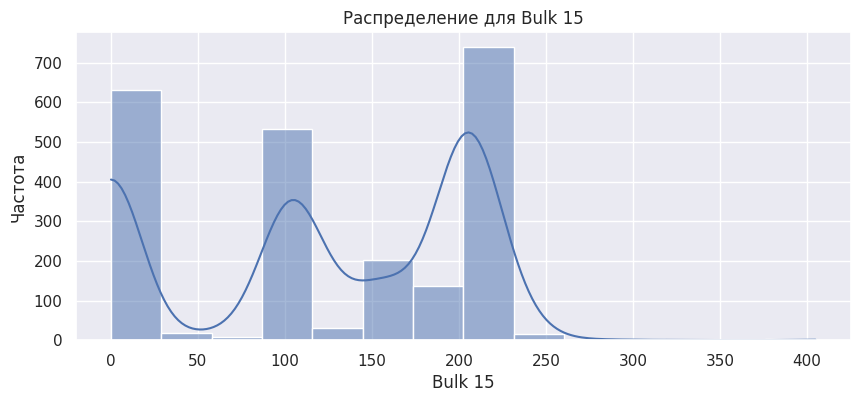

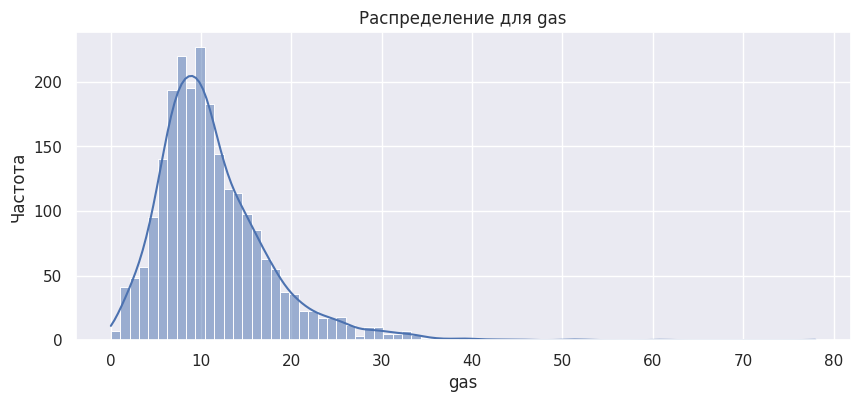

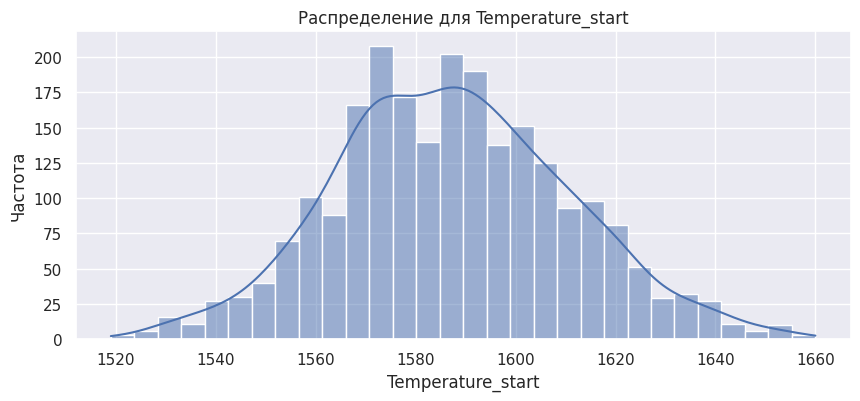

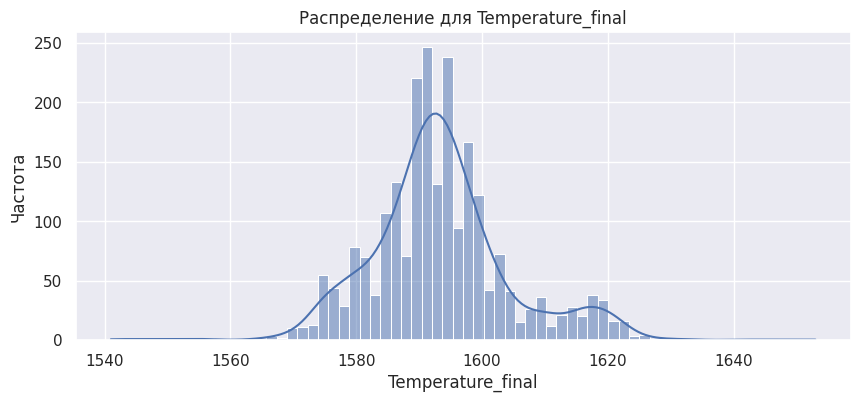

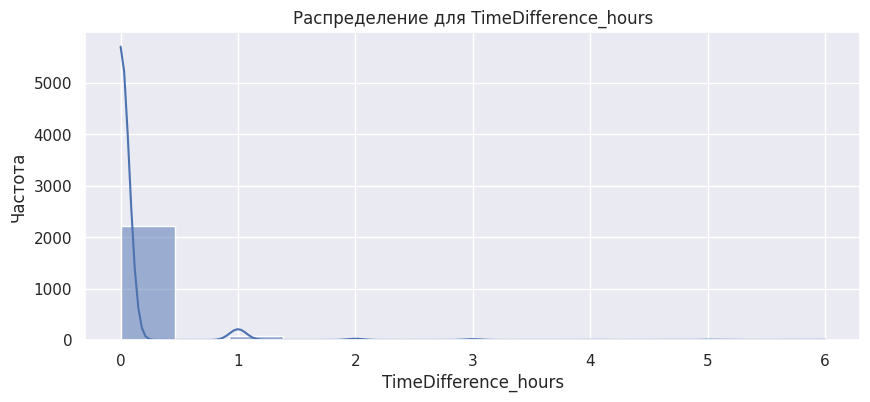

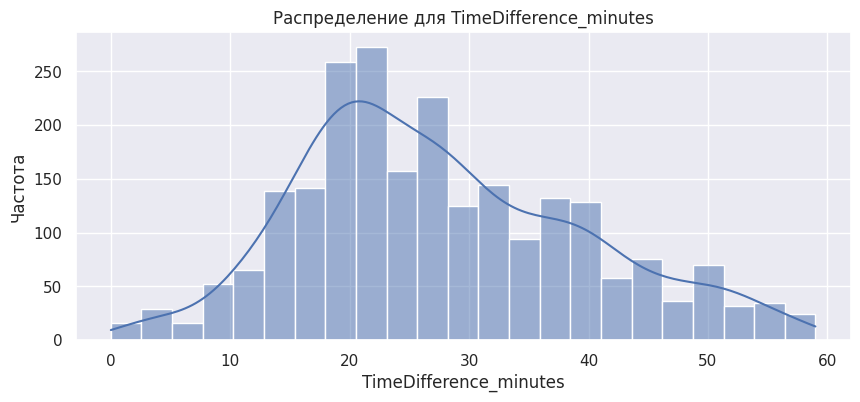

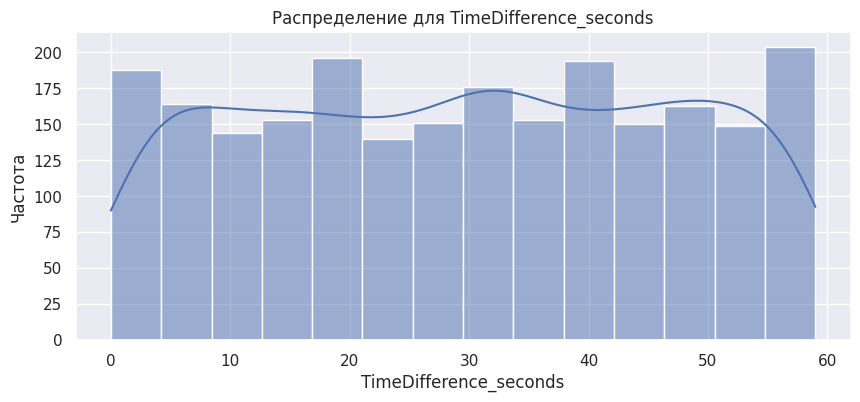

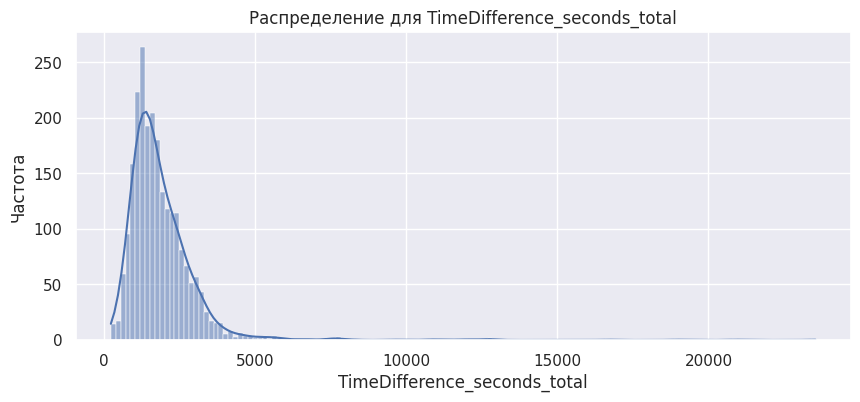

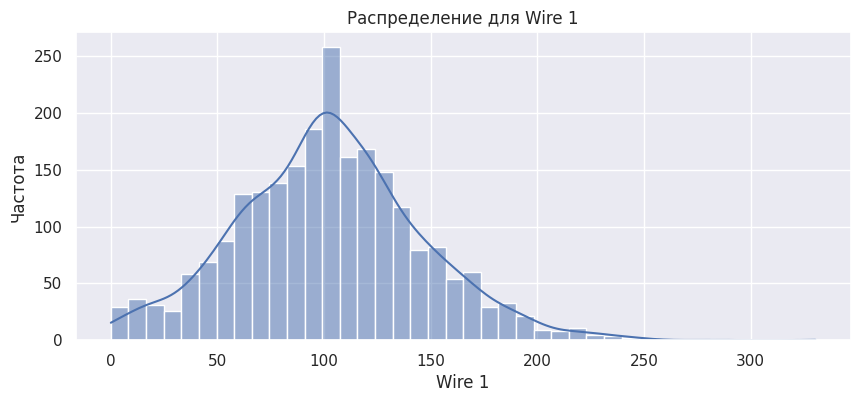

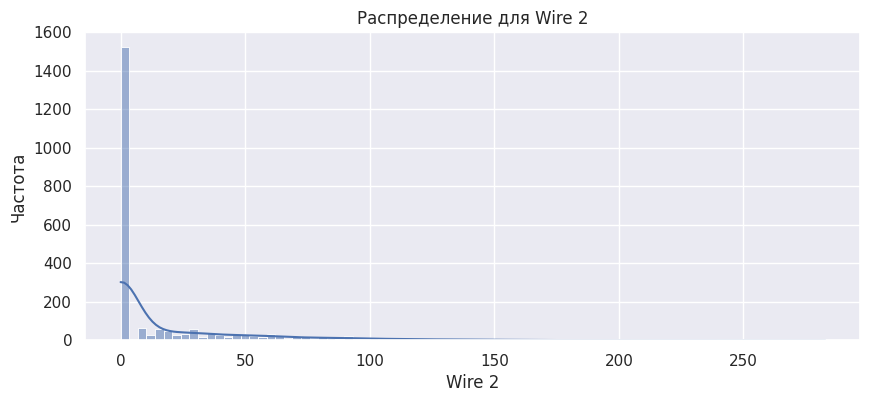

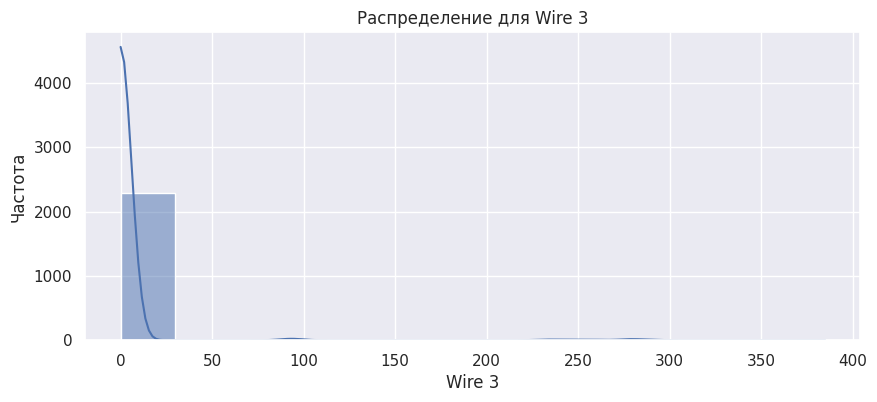

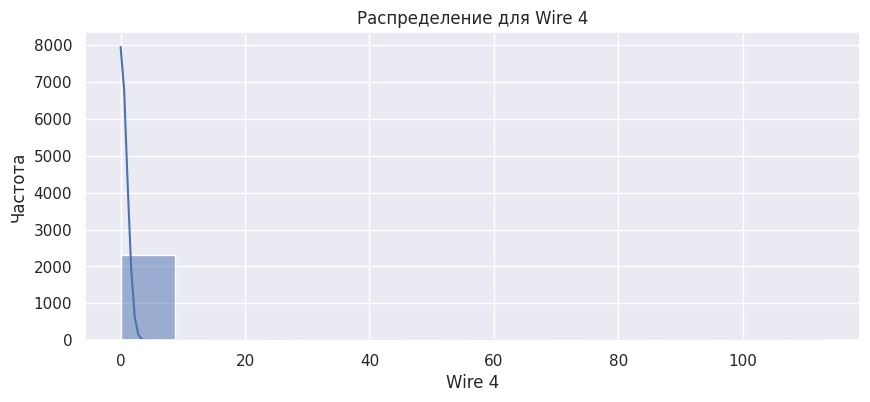

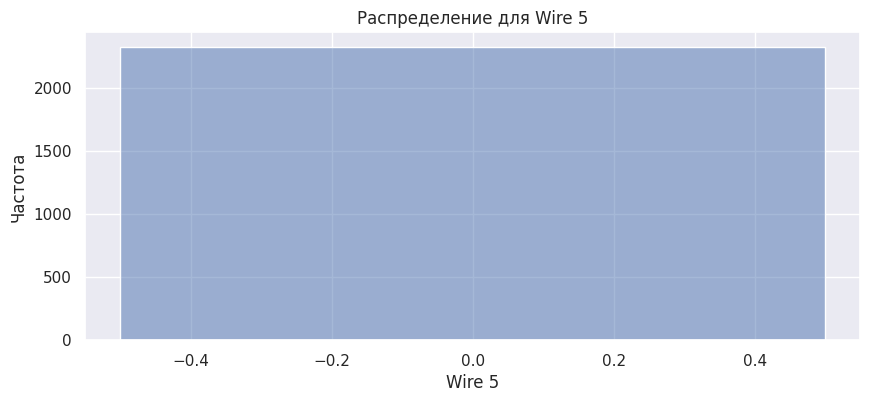

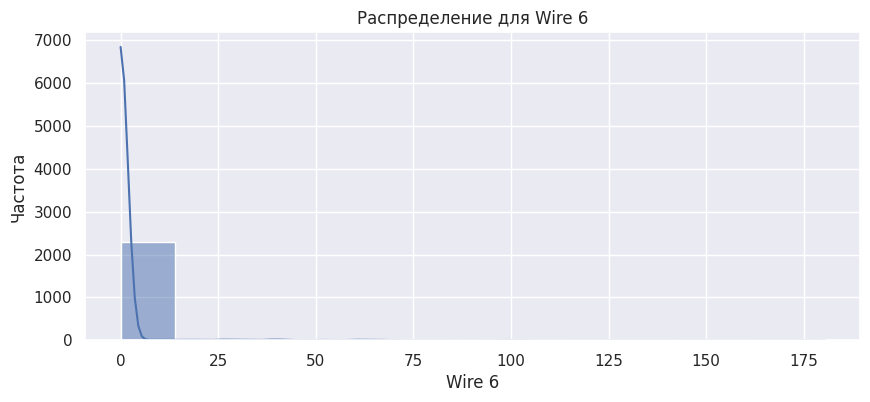

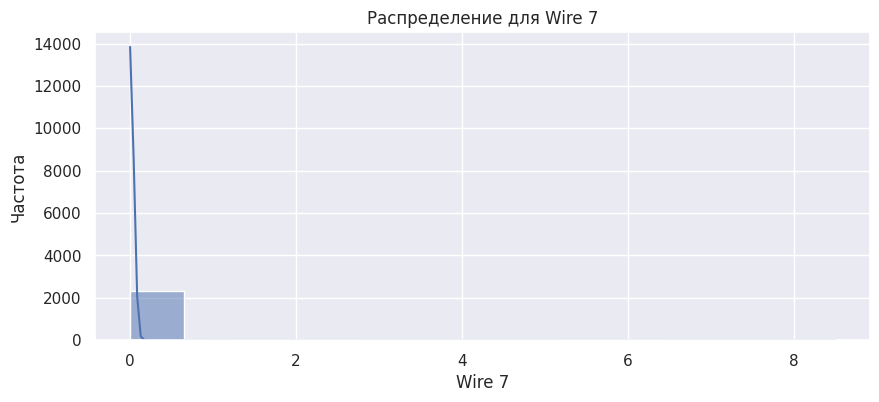

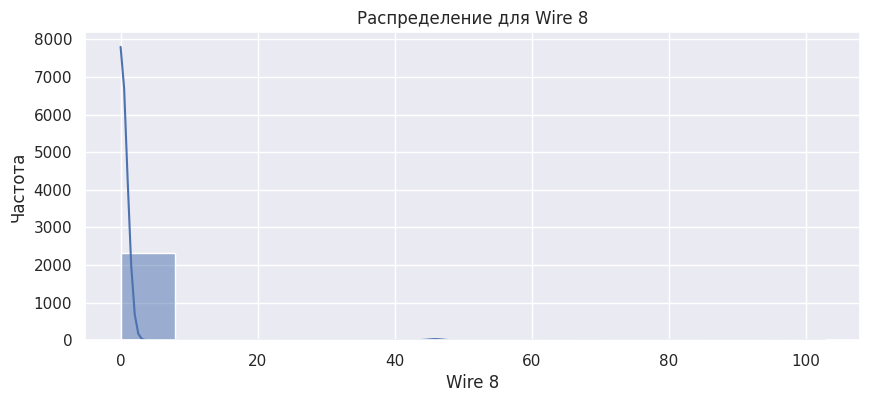

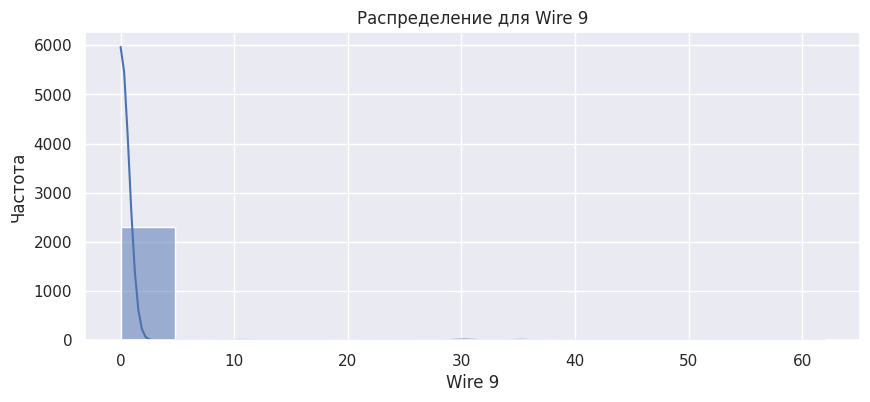

In [ ]:
#выведем распределения всех числовых признаков
plot_distributions(merged_df, merged_df.columns)

Наши числовые признаки в больше степени представлены распределениями близкими к нормальному, для некоторых из переменных `Wire` и `Bulk` имеют место экспоненциальные и равномерные распределения.

Возможно, стоит удалить признаки, с равномерным распределением, а именно `Wire 7` и `Wire 5`, так как в данном столбце содержится слишком много нулей и всего пару ненунлевых значений.

Остальные признаки стоит оставить, так как для модели они будут полезными ввиду разнообразности данных в них и распределений, которые они содержат.

### 2.2.10 Корреляционный анализ признаков

interval columns not set, guessing: ['ActivePower', 'ReactivePower', 'HeatingTime_minutes', 'HeatingTime_seconds', 'HeatingTime_seconds_total_median', 'HeatingTime_seconds_total', 'TotalPower', 'TotalPower^2', 'PowerRatio', 'PowerRatio^2', 'TotalEnergy', 'ActivePower^2', 'ReactivePower^2', 'log_ActivePower', 'log_ReactivePower', 'log_TotalPower', 'log_TotalEnergy', 'multiplication_Powers', 'NumberOfLaunches', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gas', 'Temperature_start', 'Temperature_final', 'TimeDifference_hours', 'TimeDifference_minutes', 'TimeDifference_seconds', 'TimeDifference_seconds_total', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


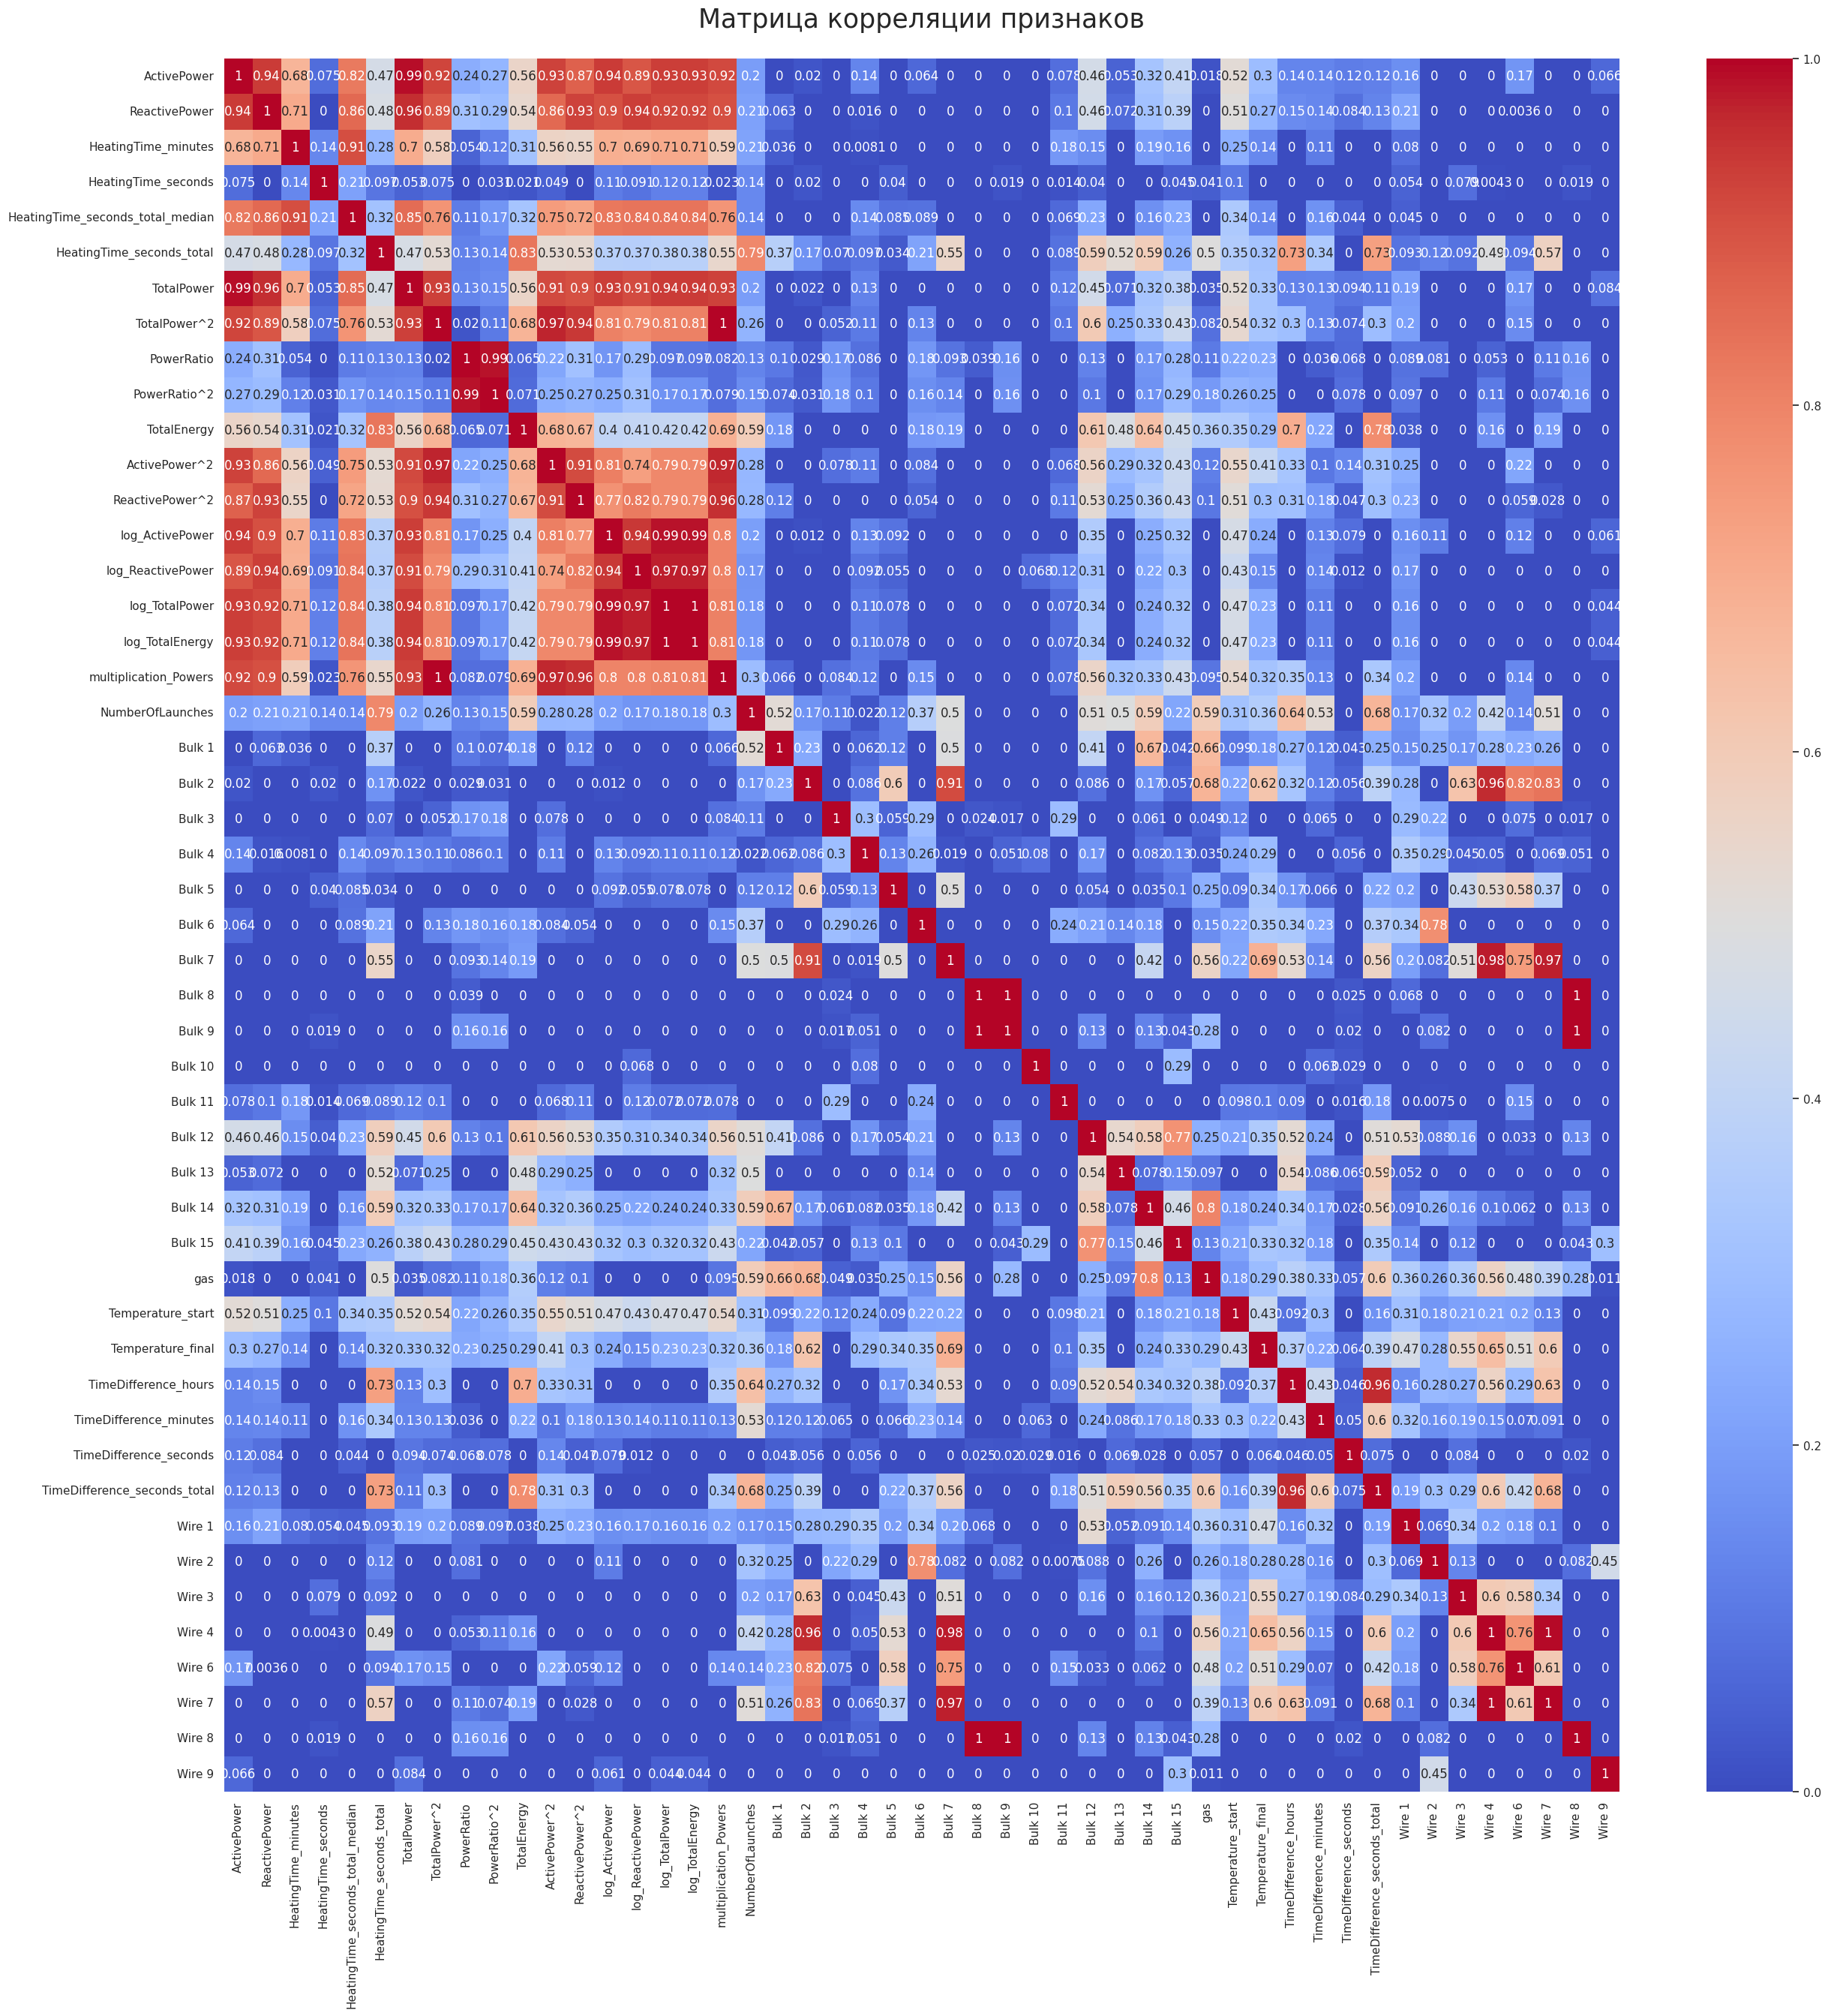

In [ ]:
#corr_matrix = merged_df.phik_matrix()

plt.figure(figsize=(30, 30))
sns.heatmap(merged_df.phik_matrix(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляции признаков', fontsize=25, pad=30)
plt.show()

У нас есть сильноскоррелированные данные. Во избежание обмана модели из-за возникновения мультиколлениарности удалим признаки, которые имеют коэффициент корреляции более 0.95

Столбцы для удаления: `TotalPower`, `TotalPower^2`, `ActivePower^2`, `log_ActivePower`, `log_ReactivePower`, `log_TotalPower`, `log_TotalEnergy`, `multiplication_Powers`, `PowerRatio`, `Wire 4`, `Wire 7`, `Wire 8`, `Bulk 8`

In [ ]:
drop_columns = [
    'TotalPower', 'TotalPower^2', 'ActivePower^2', 'log_ActivePower', 'log_ReactivePower', 'log_TotalPower',
    'log_TotalEnergy', 'multiplication_Powers', 'PowerRatio', 'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Bulk 8',
    #также добавим в этот список столбец с целевым признаком
    'Temperature_final'
]

In [ ]:
merged_df.columns

Index(['ActivePower', 'ReactivePower', 'HeatingTime_minutes',
       'HeatingTime_seconds', 'HeatingTime_seconds_total_median',
       'HeatingTime_seconds_total', 'TotalPower', 'TotalPower^2', 'PowerRatio',
       'PowerRatio^2', 'TotalEnergy', 'ActivePower^2', 'ReactivePower^2',
       'log_ActivePower', 'log_ReactivePower', 'log_TotalPower',
       'log_TotalEnergy', 'multiplication_Powers', 'NumberOfLaunches',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'gas', 'Temperature_start', 'Temperature_final',
       'TimeDifference_hours', 'TimeDifference_minutes',
       'TimeDifference_seconds', 'TimeDifference_seconds_total', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9'],
      dtype='object')

## 3. Обучение модели

3.1 Подготовка тренировочных и тестовых данных

In [ ]:
features = merged_df.drop(
    columns=drop_columns
)
target = merged_df.Temperature_final

X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size = 0.25,
    random_state=RANDOM_STATE
)

print(f'Размеры тренировочных датасетов с фичачами {X_train.shape} и таргетами {y_train.shape}')
print(f'Размеры тестовых датасетов с фичачами {X_test.shape} и таргетами {y_test.shape}')

#print(X_train.isna().sum())
#print(X_test.isna().sum())

Размеры тренировочных датасетов с фичачами (1743, 35) и таргетами (1743,)
Размеры тестовых датасетов с фичачами (582, 35) и таргетами (582,)


In [ ]:
#нормализация данных
standart_scaler = StandardScaler()
X_train = standart_scaler.fit_transform(X_train)
X_test = standart_scaler.transform(X_test)

In [ ]:
#скорер для перекрестной проверки с подбором гиперпараметров
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### 3.2 `LinearRegression`

In [ ]:
param_grid_lr = {
    #'fit_intercept': [True, False],
    #'positive': [True, False]
}

In [ ]:
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(
        fit_intercept=True,
        copy_X=True,
        positive=False,
        n_jobs=-1
    ),
    param_grid=param_grid_lr,
    scoring=mae_scorer,
    cv=KFold(
        n_splits=3,
        shuffle=True,
        random_state=RANDOM_STATE
    ),
    n_jobs=-1,
    verbose=5
)

grid_search_lr.fit(X_train, y_train)

#лучшие параметры и соответствующее значение MAE
print(f"Лучшие параметры: {grid_search_lr.best_params_}")
print(f"Лучшая MAE: {-grid_search_lr.best_score_:.2f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры: {}
Лучшая MAE: 5.66


### 3.3 `Ridge regression`

In [ ]:
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'tol': [0, 1e-7, 1e-9],
    'solver': ['svd', 'lsqr']
}

grid_search_ridge = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid_ridge,
    scoring=mae_scorer,
    cv=KFold(
        n_splits=3,
        shuffle=True,
        random_state=RANDOM_STATE
    ),
    n_jobs=-1,
    verbose=5
)

grid_search_ridge.fit(X_train, y_train)

#лучшие параметры и соответствующее значение MAE
print(f"Лучшие параметры: {grid_search_ridge.best_params_}")
print(f"Лучшая MAE: {-grid_search_ridge.best_score_:.2f}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Лучшие параметры: {'alpha': 1, 'fit_intercept': True, 'solver': 'lsqr', 'tol': 1e-09}
Лучшая MAE: 5.66


### 3.4 `RandomForestRegressor`

In [ ]:
param_grid_rfr = {
    'n_estimators': [80, 100],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        criterion='absolute_error',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    param_grid=param_grid_rfr,
    scoring=mae_scorer,
    cv=KFold(
        n_splits=3,
        shuffle=True,
        random_state=RANDOM_STATE
    ),
    n_jobs=-1,
    verbose=5
)

grid_search_rfr.fit(X_train, y_train)

#лучшие параметры и соответствующее значение MAE
print(f"Лучшие параметры: {grid_search_rfr.best_params_}")
print(f"Лучшая MAE: {-grid_search_rfr.best_score_:.2f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие параметры: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая MAE: 6.23


### 3.4 `CatboostRegressor`

In [ ]:
#параметры модели
param_cbr = {
    'learning_rate': 0.1,
    'iterations': 5000,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'score_function': 'L2',
    'random_state': RANDOM_STATE,
    'early_stopping_rounds': 200,
    'verbose': False
}

#параметры для кросс-валидации
param_grid_cbr={
    'depth': [1, 2, 3, 4, 6, 8],
    'l2_leaf_reg': [1, 10, 100]
}

In [ ]:
%matplotlib inline


model_cbr = CatBoostRegressor(**param_cbr)
grid_search_cbr = model_cbr.grid_search(
    param_grid_cbr,
    X=X_train,
    y=y_train,
    cv=3,
    partition_random_seed=RANDOM_STATE,
    shuffle=True,
    train_size=0.85,
    verbose=False,
    plot=True
)

print(f"Лучшие параметры: {grid_search_cbr['params']}")
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.80197512
bestIteration = 3525

Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.767855999
bestIteration = 2756

Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.773778041
bestIteration = 3091

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.343170521
bestIteration = 750

Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.561907633
bestIteration = 2160

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.070179544
bestIteration = 2090

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.404345789
bestIteration = 1011

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.603816411
bestIteration = 1149

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.526076173
bestIteration = 915

Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.133810347
bestIteration =

In [ ]:
cv_results = grid_search_cbr['cv_results']
best_cv_score = np.min(cv_results['test-MAE-mean']) if 'test-MAE-mean' in cv_results else None
print(f"Лучшая метрика MAE на кросс-валидации: {best_cv_score:.2f}")

Лучшая метрика MAE на кросс-валидации: 5.85


### 3.5 Полносвязная нейронная сеть

In [ ]:
def create_model(input_shape, neurons_per_layer, output_shape, lr):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Используем слой Input
    model.add(Dense(neurons_per_layer[0]))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    for neurons in neurons_per_layer[1:]:
        model.add(Dense(neurons))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
    model.add(Dense(output_shape, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_absolute_error')
    return model

In [ ]:
#определим константные значения, функцию для остановки и гиперпараметры
nn_model = None
best_mae = np.inf

input_shape = X_train.shape[1]
output_shape = 1

learning_rates= [0.001, 0.01]
neurons = [[35, 18, 9], [70, 35, 10], [18, 9, 4]]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=750,
    restore_best_weights=True,
    verbose=1
)

#разделение на фолды для кросс-валидации
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
np.random.seed(RANDOM_STATE)
python_random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

results = []
#итерация по гиперпараметрам
for learning_rate in learning_rates:
    for neurons_per_layer in neurons:
        fold_mae = []

        #кросс-валидация
        for train_index, val_index in kf.split(X_train):
            X_train_k, X_val_k = X_train[train_index], X_train[val_index]
            y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]

            model = create_model(input_shape, neurons_per_layer, output_shape, learning_rate)
            history = model.fit(
                X_train_k, y_train_k,
                validation_data=(X_val_k, y_val_k),
                epochs=1500, batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )

            mae = min(history.history['val_loss'])
            fold_mae.append(mae)
            del model, history

        avg_mae = np.mean(fold_mae)
        results.append((learning_rate, neurons_per_layer, avg_mae))
        print(f'Learning rate {learning_rate}, neurons per layer {neurons_per_layer}, среднее MAE на 3-х фолдах: {avg_mae:.2f}')

#сортировка результатов для вывода лучшей комбинации
results.sort(key=lambda x: x[2])
best_lr, best_neurons, best_mae = results[0]
print(f"Лучшие параметры: learning_rate = {best_lr}, neurons = {best_neurons}, среднее MAE = {best_mae:.2f}")

Epoch 1334: early stopping
Restoring model weights from the end of the best epoch: 584.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Learning rate 0.001, neurons per layer [35, 18, 9], среднее MAE на 3-х фолдах: 6.07
Epoch 1296: early stopping
Restoring model weights from the end of the best epoch: 546.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Learning rate 0.001, neurons per layer [70, 35, 10], среднее MAE на 3-х фолдах: 5.79
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 750: early stopping
Restoring model weights from the end of the best epoch: 1.
Learning rate 0.001, neurons per layer [18, 9, 4], среднее M

In [ ]:
np.random.seed(RANDOM_STATE)
python_random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

nn_model = create_model(input_shape, best_neurons, output_shape, best_lr)

nn_history = nn_model.fit(
  X_train, y_train,
  epochs=200,
  batch_size=64,
  validation_split=0.15,
  callbacks=[EarlyStopping(
      monitor='val_loss',
      patience=40,
      restore_best_weights=True,
      verbose=1
  )],
  verbose=2
)

Epoch 1/200
24/24 - 4s - 180ms/step - loss: 1593.2012 - val_loss: 1592.0878
Epoch 2/200
24/24 - 0s - 4ms/step - loss: 1592.0670 - val_loss: 1590.6765
Epoch 3/200
24/24 - 0s - 4ms/step - loss: 1590.0343 - val_loss: 1588.2816
Epoch 4/200
24/24 - 0s - 5ms/step - loss: 1586.8938 - val_loss: 1584.6029
Epoch 5/200
24/24 - 0s - 6ms/step - loss: 1582.5417 - val_loss: 1579.5983
Epoch 6/200
24/24 - 0s - 6ms/step - loss: 1576.9309 - val_loss: 1573.4866
Epoch 7/200
24/24 - 0s - 6ms/step - loss: 1570.0420 - val_loss: 1566.1444
Epoch 8/200
24/24 - 0s - 5ms/step - loss: 1561.8699 - val_loss: 1557.1235
Epoch 9/200
24/24 - 0s - 4ms/step - loss: 1552.4166 - val_loss: 1547.3710
Epoch 10/200
24/24 - 0s - 4ms/step - loss: 1541.6888 - val_loss: 1534.9265
Epoch 11/200
24/24 - 0s - 4ms/step - loss: 1529.6957 - val_loss: 1523.0044
Epoch 12/200
24/24 - 0s - 4ms/step - loss: 1516.4475 - val_loss: 1510.1406
Epoch 13/200
24/24 - 0s - 6ms/step - loss: 1501.9554 - val_loss: 1494.5765
Epoch 14/200
24/24 - 0s - 6ms/st

In [ ]:
best_val_loss = min(nn_history.history['val_loss'])

#печать лучшей валидационной потери, которая является MAE
print(f"Лучшая MAE на валидационных данных: {best_val_loss:.2f}")

Лучшая MAE на валидационных данных: 5.34


### 3.6 Выводы по лучшей модели

Самые лучшие метрики при подборе гиперпараметров и кросс-валидации показала модель полносвязной нейронной сети. Результат ошибки MAE на валидационных данных получился равным 5.34, что является неплохим результатом, учитывая критерий заказчика. Однако предстоит проверить ее работу на тестовых данных.

Остальные модели (линейный регрессии, лес решений, бустинг) показали примерно схожие результаты, однако у них ошибка оказалась больше на 0.5-1 MAE, что в контексте нашей размерности не такая большая разница. Поэтому в случае необходимости можно будет использовать данные модели для оценки важности признаков, если это будет затруднительно сделать с моделью NN.

## 4 Тестирование работы модели и демонстрации ее работы

### 4.1 Сравнение работы лучшей модели с константной

In [ ]:
predictions = nn_model.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions)
test_r2 = r2_score(y_test, predictions)
print(f'Тестовая метрика MAE составила: {test_mae:.1f}')
print(f'R2_score модели: {test_r2:.1}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Тестовая метрика MAE составила: 5.6
R2_score модели: 0.5


In [ ]:
dummy_regressor = DummyRegressor(strategy='median')
dummy_regressor.fit(X_train, y_train)

predictions_dr = dummy_regressor.predict(X_test)
dr_mae = mean_absolute_error(y_test, predictions_dr)
dr_r2 = r2_score(y_test, predictions_dr)
print(f'MAE константной модели составила: {dr_mae:.1f}')
print(f'R2_score: {dr_r2:.1}')

MAE константной модели составила: 8.3
R2_score: -0.0007


Как мы видим, целевая метрика нашей лучшей модели является гораздо лучше, плюс ко всему в сравнении с константной моделью наша r2_score является отличной и говорит о том, что 60% вариабельности зависимой переменной может быть объяснено предикторами в модели. Также константная модель, что видно по второй метрике и по определению не может объяснить свои предсказания.

Поэтому для продакшена выбреем именно нашу лучшую обученную модель НС.

### 4.2 Анализ важности признаков

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=features.columns,
    mode='regression'
)

#объяснение для одного примера
exp = explainer.explain_instance(X_test[1], nn_model.predict, num_features=35)


#список фичей и их важности из объяснения
explanation = exp.as_list()

#сортировка по абсолютному значению веса для увидеть самые влиятельные признаки (большое влияние как в положительную, так и в отрицательную сторону)
explanation_sorted = sorted(explanation, key=lambda x: abs(x[1]), reverse=True)

#вывод отсортированного списка
for feature, weight in explanation_sorted:
    print(f"Feature: {feature}, Weight: {weight}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Feature: Bulk 7 <= -0.05, Weight: 10.971815849929056
Feature: ActivePower <= -0.73, Weight: -9.952769652330302
Feature: Wire 6 <= -0.11, Weight: 6.6647615748931415
Feature: TimeDifference_hours <= -0.17, Weight: 6.588231464748373
Feature: TimeDifference_seconds_total > 0.33, Weight: -6.004308263231967
Feature: Bulk 2 <= -0.07, Weight: -5.896864587061548
Feature: 0.22 < NumberOfLaunches <= 0.86, Weight: 4.615082546156291
Feature: TimeDifference_minutes > 0.71, Weight: -3.6026639293649927
Feature: -0.01 < Temperature_start <= 0.67, Weight: 3.5549030869670117
Feature: Bulk 13 <= -0.07, Weight: -3.0970854042017018
Feature: Wire 3 <= -0.11, Weight: -2.772482109882579
Feature: ReactivePower^2 <= -0.71, Weight: 2.4847543151841065
Feature: Wire 9 <= -0.09, Weight: 2.2293482864016925
Feature: PowerRatio^2 <= -0.57, Weight: -2.202281138904572
Feature: Bulk 1 > -0.29, Weight: -2.0858883427349704
Feature: ReactivePower <= -0.73, Weight: -1.93723380254965
Fe

Модель посчитала самымы важными признаками Bulk 7, Bulk 13, Bulk 2 - это количество добавляемых сыпучих материалов. Однако для различных записей из нашего датафрейма наша модель будет находить различные признаки, которые окажутся более важными для предсказания целевой метрики.

Такое возможно ввиду нелинейной зависимости нашего таргета от признаков. Проверим данное предположение с помощью диаграммы рассеяния, в котором мы сравним как распредлены таргеты в зависимости от значений одной из самых важных метрик.


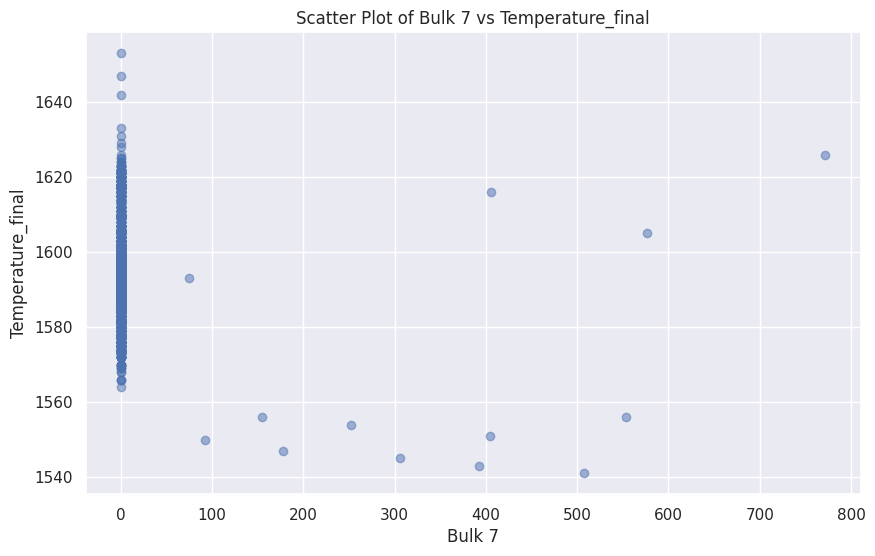

In [ ]:
x = merged_df['Bulk 7']
y = merged_df['Temperature_final']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter Plot of Bulk 7 vs Temperature_final')
plt.xlabel('Bulk 7')
plt.ylabel('Temperature_final')
plt.grid(True)
plt.show()

Судя по той информации, что была получена видна нелийнейность зависимости между фичами и таргетом, и данную нелинейность наша модель смогла хорошо уловить, учитывая результаты ее работы.

## 5. Общий вывод по работе

В ходе работы мы выгрузили наши датафреймы с серверов работодателя.
- Выполнили осмотр и анализ данных;
- Произвели необходимые очистки данных от пропусков и аномалий согласно рекомендациям, полученным от заказчика;
- Оценили распределения наших числовых переменных в смердженной таблице и сделали необходимые выводы;
- Реализовали ML-модели на основе линейной регрессии, леса решений, градиентного бустинга и нейронных сетей;
- Выбрали лучшую модель среди всех и протестировали ее работу;
- Произвели сравнение её с константной моделью;
- Выявили наиболее весомые для модели фичи;
- Сделали вывод о нелинейной зависимости целевой переменной от признаков.

В качестве рекомендаций, которые я могу дать заказчику, можно назвать следующие моменты:
- Организовать дополнительный сбор данных, например, состав металла, тип добавляемых во время процесса материалов, их температуры плавления, температуру среды в цеху и др;
- Стандартизировать число замеров для каждого из типов металлов;